## Install related package

In [3]:
# %pip install packages if not available on kernel
%pip install plotly
%pip install cufflinks
%pip install optuna
%pip install catboost
%pip install shap
%pip install scikit-learn==0.24

     |████████████████████████████████| 308 kB 12.2 MB/s 
     |████████████████████████████████| 209 kB 87.0 MB/s 
     |████████████████████████████████| 80 kB 11.0 MB/s 
     |████████████████████████████████| 75 kB 5.0 MB/s 
     |████████████████████████████████| 49 kB 7.4 MB/s 
     |████████████████████████████████| 149 kB 88.5 MB/s 
     |████████████████████████████████| 112 kB 93.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=5e188f222003d1466ea7047d1d153acea00ff386e8ffc2848b3174480ddbb608
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 76.3 MB 1.9 MB/s 
     |████████████████████████████████| 564 kB 14.4 MB/s 
     |████████████████████████████████| 22.3 MB 14.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      

## Check GPU Type, reboot if GPU is not P100 (the best spec)

In [2]:
!nvidia-smi

Sun Dec  5 08:59:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# W207-4-Fall21-Final Project-Baseline Submission

### Lynn Marciano, Jason Cheung, Wanyu Li
---------

## Project Topic: House Prices - Advanced Regression Techniques
**Goal**: We utilise the Ames Housing Dataset describing different aspects of residential homes in Ames, Iowa, to form a predictive model for house prices. Then, we aim to improve prediction accuracy through exploratory data analysis, feature engineering, and PCA. Finally, we process the data through random forests, KNN and XGBoosting to identify the best prediction. 

Kaggle Competition Reference:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques


---


**Data Description**
The <i>Ames Housing Dataset</i> was compiled by Dead De Cock for the use in data science education. The dataset contains 79 explanatory variables describing different aspects of residentials homes that may affect their final price.

Dataset:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data


---


**Data Cleansing and Ordinal Encoding**
We perform data cleansing to remove features with high amounts of missing values. We remove these features to alleviate our model building and to achieve greater accuracy.

Reference:
https://www.kaggle.com/mitramir5/missing-values-ordinal-data-and-stories/notebook


---



---


**XGB**
Although gradient boosting is not performed in our baseline project. We plan to investigate these benefits. We feel that combining multiple models will enhance in our ability to predict housing prices more accurately by utilizing an initial model as a potential feature.

Reference: https://www.kaggle.com/filterjoe/house-price-feature-engineering-using-only-xgboost#Step-2---Feature-Utility-Scores

Mout the driver (specific to colab)

In [1]:
# Run the code below. It will prompt you to enter a one-time password
# that will automatically generate for you
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
cd drive/MyDrive/CAL/W207/house-prices-modeling-analysis/notebook
# for final repo

/content/drive/MyDrive/CAL/W207/house-prices-modeling-analysis/notebook


In [13]:
# Make sure you have a short cut for the 207FinalPJ folder in your Drive
# Right click on the folder and choose "Add Shortcut to Drive"
# for Wanyu
# cd drive/MyDrive/CAL/W207/W207FinalPJ/020_code 
# for Jason
# % cd drive/MyDrive/W207FinalPJ/020_code

SyntaxError: ignored

## Import Libraries

In [7]:
import pandas as pd
import numpy as np

import sklearn
import warnings
import plotly

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,Normalizer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from sklearn.decomposition import PCA

from catboost import CatBoostRegressor,Pool,cv

import optuna
from optuna.samplers import TPESampler
from catboost.utils import eval_metric

# Make Plotly work in your Jupyter Notebook
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor


# Use Plotly locally
cf.go_offline()

## Splitting the Data

We split our data into training, validation (dev), and test sets

In [11]:
# importing the train data
df_original=pd.read_csv("../data/train.csv")
# df_test=pd.read_csv("../010_data/test.csv")

In [ ]:
# check shape of train data
df_original.shape
# df_test.shape

(1460, 81)

We plan to explore the prediction accuracy in a few different ways, so we will split the housing sale price into different quantiles and reserve 20% of the data for training (dev). 


In the code below, we separated the data into 10 different percentile groups.This allows us to eliminate the potential bias results on larger target values when we use RMSE to measure the performance of our models.

In [12]:
# split data into 10 quantitles
temp=pd.qcut(df_original['SalePrice'],[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
             labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100'])

# split data into train and dev datasets
X_train, X_dev, _, _ = train_test_split(temp, temp, test_size=0.2, random_state=42,stratify =temp)

In [13]:
# split data into train and dev
df_train=df_original.loc[X_train.index].copy()
df_dev=df_original.loc[X_dev.index].copy()

In [14]:
# save train and dev data locally to maintain original state
df_train.to_csv('../data/W207_train.csv',index=False)
df_dev.to_csv('../data/W207_dev.csv',index=False)
df_original.to_csv('../data/W207_original.csv',index=False)

## Import the pre-splited data
Saving the data we prepared above as backup (refer to the cells above). We'll utilize the data we originally saved in our analysis.

In [15]:
# importing the data
df_train=pd.read_csv('../data//W207_train.csv')
df_dev=pd.read_csv('../data//W207_dev.csv')
df_original=pd.read_csv('../data/W207_original.csv')

## Data Cleansing

### Handle missing values
We want to find out if there are any missing values (nulls) in the dataset, and if there are nulls, we want to determine how much of the data is missing.

In [16]:
# show top 10 columns with highest percentage of missing values
(df_train.isnull().sum()/df_train.shape[0]).sort_values(ascending=False)[:10]

PoolQC          0.994007
MiscFeature     0.963185
Alley           0.937500
Fence           0.807363
FireplaceQu     0.475171
LotFrontage     0.181507
GarageCond      0.053938
GarageType      0.053938
GarageYrBlt     0.053938
GarageFinish    0.053938
dtype: float64

The features listed above have the highest percentages of missing values. However, we will not remove any of these columns from the dataset because we want to retain as much original information as possible.  Instead, we will fix these columns through data processing in subsequent codes below. 

In [17]:
# drop the id column
col_drop=['Id']

We want define the different data types in our dataset to give us a better understanding of what types of features are available.

We will categorize the features into 4 different data types: categorical, ordinal, continuous numerical and integer numerical.

In [18]:
# Name categorical variables
col_cat=['MSSubClass', #building class
         'MSZoning', #general zoning classification
         'Street', #road access
         'LandContour', #flatness of property
         'Utilities', #type of utilities avail
         'LotConfig', #lot configuration
         'LandSlope', #slope of property
         'Neighborhood', #physical neighborhoods within Ames
         'Condition1', #proximity to certain landmarks
         'Condition2', #proximity to certain landmarks (if more than one present)
         'BldgType', #type of dwelling
         'HouseStyle', #how many floors/type of dwelling
         'RoofStyle', #type of roof
         'RoofMatl', #roof material
         'Exterior1st', #exterior covering on the house
         'Exterior2nd', #exterior covering on the house (if more than one present)
         'MasVnrType', #masonry veneer type
         'Foundation', #type of foundation
         'Heating', #type of heating
         'CentralAir', #boolean if central air is avail
         'Electrical', #type of electrical system
         'GarageType', #garage location
         'SaleType', #type of sale
         'SaleCondition', #condition of sale
         'MiscFeature', #Miscellaneous feature not covered in other categories
        ]

# Name ordinal variables -- these are string value ordinals
col_order=['ExterQual', #Evaluates the quality of the material on the exterior 
           'LotShape', #general shape of the property
           'ExterCond', #evaluate present condition of material on exterior
           'BsmtQual', #evaluate height of basement
           'BsmtCond', #evaluate present condition of the basement
           'BsmtExposure', #evaluate ability to walkout or garden level walls
           'BsmtFinType1', #rating of basement finished area
           'BsmtFinType2', #rating of basement finished area (if multiple)
           'HeatingQC', #heating quality & condition
           'Functional', #home functionality (assume typical unless deductions warranted)
           'KitchenQual', #kitchen quality
           'GarageQual', #garage quality
           'GarageFinish', #evaluate interior finish of garage
           'GarageCond', #evaluate garage condition
           'PavedDrive', #evaluate type of driveway based on pavement
           'PoolQC',  # Pool quality
           'Fence', # Fence quality
           'FireplaceQu', # Fireplace quality   
           'Alley', #Type of alley access      
          ]

# Already numerical values -- these may contain numerical ordinal values
col_num_continuous=[
         'LotArea', #Lot size in square feet
         'MasVnrArea', #Masonry veneer area in square feet
         'BsmtFinSF1', #Type 1 finished square feet
         'BsmtFinSF2', #Type 2 finished square feet
         'BsmtUnfSF', #Unfinished square feet of basement area
         'TotalBsmtSF', #Total square feet of basement area
         '1stFlrSF', #First Floor square feet
         '2ndFlrSF', #Second floor square feet
         'LowQualFinSF', #Low quality finished square feet (all floors)
         'GrLivArea', #Above grade (ground) living area square feet
         'GarageArea', #Size of garage in square feet
         'WoodDeckSF', #Wood deck area in square feet
         'OpenPorchSF', #Open porch area in square feet
         'EnclosedPorch', #Enclosed porch area in square feet
         '3SsnPorch', #Three season porch area in square feet
         'ScreenPorch', #Screen porch area in square feet
         'PoolArea', #Pool area in square feet
         'MiscVal', #Value of miscellaneous feature
         'LotFrontage',#Linear feet of street connected to property
        ]

col_num_int=['OverallQual', #evaluate the overall material and finish of the house
         'OverallCond', #evaluate Overall condition rating
         'BsmtFullBath', #Basement full bathrooms
         'BsmtHalfBath', #Basement half bathrooms
         'FullBath', #Full bathrooms above grade
         'HalfBath', #Half baths above grade
         'BedroomAbvGr', #Number of bedrooms above basement level
         'KitchenAbvGr', #Number of kitchens
         'TotRmsAbvGrd', #Total rooms above grade (does not include bathrooms)
         'Fireplaces', #Number of fireplaces
         'GarageCars', #Size of garage in car capacity
         'YearBuilt', #year built
         'YearRemodAdd', #year remodels were added
         'MoSold', #month sold
         'YrSold', #year sold
         'GarageYrBlt' #year garage was built
            ]



In [19]:
# Define target variable
col_target=['SalePrice']

In [20]:
# Get number of columns from df_train
len(df_train.columns.tolist())

81

In [21]:
# check that we have counted for all the variable.  Should have 81 as the result
temp=col_cat+col_order+col_num_continuous+col_num_int+col_target+col_drop
len(temp)

81

Next, we want to define all the different ordinal string values for our ordinal features, as well as all the different categorical values for our categorical features.  These values are available in the data dictionary from the Kaggle competition link above.

There are several reasons why we want to go through this step:


1.   We want to make sure we can interpret all of the unique values from our ordinal and categorical values. The data dictionary that comes with the dataset on Kaggle provides a description to the unique values within each feature. Utilizing the data dictionary, we want to be certain that the unique values from the dataset correlate with the values from the data dictionary file. 
2.   We want to reclassify some of the categorical variables into binary outputs (0,1).  We need to have a thorough understanding of all the unique values for us to properly reclassify the variables.
3.   We want to recode the ordinal values from text to integers, so we can sort the rankings. In order to do that, we need to know what the values mean. 





In [22]:
# define categorical values
cat_values={
    'MSZoning': ['None','A','C','FV','I','RH','RL', 'RP' , 'RM'],
    'Street': ['None', 'Pave', 'Grvl'],
    'LandContour': ['None', 'Lvl', 'Bnk', 'HLS', 'Low'],
    'Utilities': ['None', 'AllPub', 'NoSewr', 'NoSeWa', 'ELO'],
    'LotConfig': ['None', 'Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'],
    'LandSlope': ['None', 'Gtl', 'Mod', 'Sev'],
    'Neighborhood': ['None',"Blmngtn","Bluestem","BrDale","BrkSide",
                     "ClearCr","CollgCr","Crawfor","Edwards",
                     "Gilbert","IDOTRR","MeadowV","Mitchel",
                     "Names","NoRidge","NPkVill","NridgHt",
                     "NWAmes","OldTown","SWISU","Sawyer",
                     "SawyerW","Somerst","StoneBr","Timber","Veenker"],
    'Condition1': ['None',  'Artery', 'Feedr',  'Norm',
                   'RRNn',  'RRAn', 'PosN', 'PosA',
                   'RRNe',  'RRAe'],
    'Condition2':  ['None',  'Artery', 'Feedr',  'Norm',
                    'RRNn',  'RRAn', 'PosN', 'PosA',
                    'RRNe',  'RRAe'],
    'BldgType': ['None', '1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'TwnhsI'],
    'HouseStyle': ['None',  '1Story',  '1.5Fin',  '1.5Unf', 
                   '2Story',  '2.5Fin',  '2.5Unf',  'SFoyer',  'SLvl'],
    'RoofStyle': ['None', 'Gable', 'Hip', 'Gambrel', 
                  'Mansard', 'Flat', 'Shed'],
    'RoofMatl': ['None',  'ClyTile', 'CompShg',  'Membran',  
                 'Metal',  'Roll', 'Tar&Grv',  'WdShake',  'WdShngl'],
    'Exterior1st': ['None',  'AsbShng',  'AsphShn',  'BrkComm',  
                    'BrkFace',  'CBlock',  'CemntBd',  'HdBoard',
                    'ImStucc', 'MetalSd',  'Other',  
                    'Plywood',  'PreCast',  'Stone',  
                    'Stucco', 'VinylSd', 'Wd Sdng',  'WdShing'],
    'Exterior2nd': ['None',  'AsbShng',  'AsphShn',  'BrkComm',  
                    'BrkFace',  'CBlock',  'CemntBd',  'HdBoard',
                    'ImStucc', 'MetalSd',  'Other',  
                    'Plywood',  'PreCast',  'Stone',  
                    'Stucco', 'VinylSd', 'Wd Sdng',  'WdShing'],
    'MasVnrType': ['None', 'BrkFace', 'Stone', 'BrkCmn'],
    'Foundation': ['None', 'PConc', 'CBlock', 'BrkTil', 
                   'Wood', 'Slab', 'Stone'],
    'Heating': ['None', 'GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'],
    'CentralAir': ['None', 'Y', 'N'],
    'Electrical': ['None', 'SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'],
    'GarageType': ['None', 'Attchd', 'Detchd', 'BuiltIn', 
                   'CarPort', 'Basment', '2Types'],
    'SaleType': ['None', 'WD','CWD', 'VWD', 'New', 'COD',
                'ConLD',  'ConLI',  'ConLw',  'Con',  'Oth'],
    'SaleCondition': ['None',  'Normal',  'Abnorml',  'Partial',  'AdjLand',  'Alloca',  'Family'], 
    'MSSubClass':['None',20,30,40,45,50,60,70,75,80,85,90,120,150,160,180,190],
    'ExterQual':['None','Po','Fa','TA','Gd','Ex'],
    'LotShape':['None','Reg','IR1' ,'IR2','IR3'],
    'ExterCond':['None','Po','Fa','TA','Gd','Ex'],
    'BsmtQual':['None','Fa','TA','Gd','Ex'],
    'BsmtCond':['None','Po','Fa','TA','Gd','Ex'],
    'BsmtExposure':['None','No','Mn','Av','Gd'],
    'BsmtFinType1':['None','Unf','LwQ', 'Rec','BLQ','ALQ' , 'GLQ' ],
    'BsmtFinType2':['None','Unf','LwQ', 'Rec','BLQ','ALQ' , 'GLQ' ],
    'HeatingQC':['None','Po','Fa','TA','Gd','Ex'],
    'Functional':['None','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],
    'KitchenQual':['None','Fa','TA','Gd','Ex'],
    'GarageFinish':['None','Unf','RFn','Fin'],
    'GarageQual':['None','Po','Fa','TA','Gd','Ex'],
    'GarageCond':['None','Po','Fa','TA','Gd','Ex'],
    'PavedDrive':['None','N','P',  'Y'],
    'PoolQC':['None','Po','Fa','TA','Gd','Ex'],
    'MiscFeature':['None','Elev','Gar2','Othr','Shed','TenC'],
    'Alley':['None','Grvl','Pave'],
    'Fence':['None','MnWw','GdWo','MnPrv','GdPrv'],
    'FireplaceQu':['None','Po','Fa','TA','Gd','Ex'],
}

After defining all the unique values for our variables from the data dictionary file, we will check if the unique values from the dataset can be 100% matched with the unique values from the data dictionary values above.

### Define the correction map converting the missmatched keywords into regulated ones.

In [23]:
def check_invalid_value(df):
    '''check the value off the record'''
    for i in cat_values.keys():
        value_list=(cat_values[i].copy())
        value_list.append(np.nan)
        check=df[~df[i].isin(value_list)][i]
        if check.shape[0]!=0:
            if i in col_order:
                print("ordinal categorical variable")
            else:
                print("categorical variable")
            print("value error at:",i,cat_values[i])
            print("error values:",check.unique())

    
check_invalid_value(df_original)

categorical variable
value error at: MSZoning ['None', 'A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM']
error values: ['C (all)']
categorical variable
value error at: Neighborhood ['None', 'Blmngtn', 'Bluestem', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']
error values: ['NAmes' 'Blueste']
categorical variable
value error at: BldgType ['None', '1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'TwnhsI']
error values: ['Twnhs']
categorical variable
value error at: Exterior2nd ['None', 'AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing']
error values: ['Wd Shng' 'CmentBd' 'Brk Cmn']


Afer running the code, we found that the variable "MSZoning" has a value "C (all)" that cannot be matched with the values from the data dictionary file.  We believe it is a typo and the correct value should be "C", so we will recode it from "C (all)" to "C".  

There are several other cases in "Neighborhood", "BldgType" and "Exterior2nd". We will go through the same process as explained above to recode the values. 

In [24]:
missmatch_correction={"MSZoning":{'C (all)':'C'}, 
                      "Neighborhood": {'NAmes':'Names', 'Blueste':'Bluestem'},
                      # assumption:  that Twnhs is a misstypping for TwnhsI
                      "BldgType":{'Twnhs':'TwnhsI'},
                      "Exterior2nd":{'Wd Shng':'Wd Sdng', 'CmentBd':'CemntBd', 'Brk Cmn':'BrkComm'}
                     }

# check the missmatched value again

temp=df_original.replace(missmatch_correction)   

check_invalid_value(temp)

Based on the result from the code above, there are no more mismatched values.

Next, we want to recode the quanlatitive string features to ordinal string features.  For example, the variable "ExterQual" has 5 different unique values, "Ex", "Gd", "TA", "Fa" and "Po", which can be translated to "Excellent", "Good", "Average/Typical", "Fair", and "Poor", respectively.

While there is nothing wrong with these values, they are all qualative in nature and are challenging for the system to rank. We want to translate these values to numbers that can represent their ordinal positions. In the code below, we built a new data dictionary to complete the conversion.

In [25]:
# Map ordinal string values to a numerical value based on our categorical value dictionary above
orders_encoding_result={}
for ord_feat in col_order:
    ord_vals=cat_values[ord_feat]
    orders_encoding_result[ord_feat]={}
    for i in range(len(ord_vals)):
        orders_encoding_result[ord_feat][ord_vals[i]]=i
orders_encoding_result

{'Alley': {'Grvl': 1, 'None': 0, 'Pave': 2},
 'BsmtCond': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'None': 0, 'Po': 1, 'TA': 3},
 'BsmtExposure': {'Av': 3, 'Gd': 4, 'Mn': 2, 'No': 1, 'None': 0},
 'BsmtFinType1': {'ALQ': 5,
  'BLQ': 4,
  'GLQ': 6,
  'LwQ': 2,
  'None': 0,
  'Rec': 3,
  'Unf': 1},
 'BsmtFinType2': {'ALQ': 5,
  'BLQ': 4,
  'GLQ': 6,
  'LwQ': 2,
  'None': 0,
  'Rec': 3,
  'Unf': 1},
 'BsmtQual': {'Ex': 4, 'Fa': 1, 'Gd': 3, 'None': 0, 'TA': 2},
 'ExterCond': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'None': 0, 'Po': 1, 'TA': 3},
 'ExterQual': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'None': 0, 'Po': 1, 'TA': 3},
 'Fence': {'GdPrv': 4, 'GdWo': 2, 'MnPrv': 3, 'MnWw': 1, 'None': 0},
 'FireplaceQu': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'None': 0, 'Po': 1, 'TA': 3},
 'Functional': {'Maj1': 3,
  'Maj2': 2,
  'Min1': 6,
  'Min2': 5,
  'Mod': 4,
  'None': 0,
  'Sev': 1,
  'Typ': 7},
 'GarageCond': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'None': 0, 'Po': 1, 'TA': 3},
 'GarageFinish': {'Fin': 3, 'None': 0, 'RFn': 2, 'Unf': 1},
 'GarageQual': {

### Data Cleansing - Replacing null values

We impute our data here.
* if its numerical variable we fill 0.  if it's categorical data we fill 'None'.
* For the base line model, we are happy to use as it is.

In [26]:
# define converter function, to fill NAs, fix type
def ImputerConverter(df,col_num,col_order,col_cat,orders_encoding_result):
    df=df.drop(col_drop,axis=1).copy()
    df=df.replace(missmatch_correction).copy()  
    df[col_num_continuous+col_num_int]=df[col_num].fillna(0)
    df[col_num_int]=df[col_num_int].astype('int')
    df[col_order+col_cat]=df[col_order+col_cat].fillna('None')
    df[col_cat]=df[col_cat].astype(str)
    for i in col_order:
        df[i]=df[i].map(orders_encoding_result[i])
    return df

df_original_IC=ImputerConverter(df_original,col_num_continuous+col_num_int,col_order,col_cat,orders_encoding_result)
df_train_IC=ImputerConverter(df_train,col_num_continuous+col_num_int,col_order,col_cat,orders_encoding_result)
df_dev_IC=ImputerConverter(df_dev,col_num_continuous+col_num_int,col_order,col_cat,orders_encoding_result)       

In [28]:
#exporting the finalized clean dataset
df_dev_IC.to_csv('../data/W207_dev_IC.csv',index=False)
df_train_IC.to_csv('../data/W207_train_IC.csv',index=False)
df_original_IC.to_csv('../data/W207_original_IC.csv',index=False)

One final sanity check on our data to make sure there are no more missing values.

In [29]:
# confirm there are no more missing values in columns
(df_train_IC.isnull().sum()/df_train_IC.shape[0]).sort_values(ascending=False)[:10]

SalePrice        0.0
SaleCondition    0.0
RoofMatl         0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
MasVnrArea       0.0
ExterQual        0.0
ExterCond        0.0
Foundation       0.0
dtype: float64

## EDA - Exploratory Data Analysis and Feature Engineering

EDA is about understanding the distribution and basic patterns of our variables.  We will be study our target variable "SalePrice" and its relationship with other variables in this section. 

Feature engineering is about getting the most of out of our available data.  We will be transforming and creating new features for our prediction models. 

Reference: https://www.kaggle.com/dgawlik/house-prices-eda

### Set data for EDA

In [32]:
# check columns names
df_train_IC.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [33]:
#df_study is the entire dataset (with only our included columns) used to assess the dataset
df_study=df_original_IC

### Investigate the distribution of our target variable

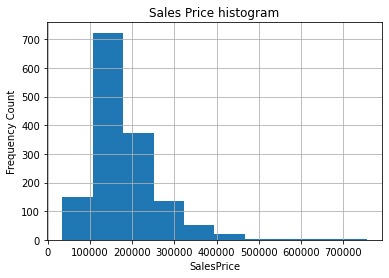

In [34]:
df_study.SalePrice.hist()
plt.xlabel('SalesPrice') 
plt.ylabel('Frequency Count') 
plt.title('Sales Price histogram')
plt.show()

From looking at the chart above, we noticed a few things.  1. The distribution for "SalePrice" is not normally distributed.  2. It is skewed right, which is within our expectation because there are some exotic houses with an expensive price tag. 

### Investigate the absolute correlation of the features with Sales Price

We want to calculate the bivariate linear relationship between "SalePrice" with other variables in the dataset to help us narrow down the variables that can strongly impact "SalePrice"

In [35]:
# Check correlation of 'SalesPrice' with other variables
corr_table=df_study.corr()
corr_table['abs_SalePrice']=abs(corr_table['SalePrice'])
corr_table.sort_values(by='abs_SalePrice',ascending=False)[['SalePrice','abs_SalePrice']]

,SalePrice,abs_SalePrice
SalePrice,1.000000,1.000000
OverallQual,0.790982,0.790982
GrLivArea,0.708624,0.708624
ExterQual,0.682639,0.682639
KitchenQual,0.659600,0.659600
GarageCars,0.640409,0.640409
GarageArea,0.623431,0.623431
BsmtQual,0.622925,0.622925
TotalBsmtSF,0.613581,0.613581
1stFlrSF,0.605852,0.605852


Based on our investigation, we can determine that these features are the most correlated with our target variable:
* OverallQual 
* GrLivArea
* ExterQual
* KitchenQual
* GarageCars
* GarageArea
* BsmtQual
* TotalBsmtSF
* 1stFlrSF

Next, we will explore other features further in the featuring engineering section.

### Feature Engineering

From above, we saw the distribution of "SalePrice" is not normally distributed and is skewed right.  We can log transform "SalePrice" to get a normal distribution.  However, if we breakdown the formula of "SalePrice", it is the product of "SalePrice per sq. ft" and "TotalArea".  Therefore, we decided to follow down the path of "SalePrice per sq. ft" to utilize as our engineered target variable.  As for "TotalArea", we thought it was most logical to combine the "Ground Living Area" with "Basement Area" since the Basement can be considered as indoor living area.

In [36]:
def FeatureEngineering(df,pca=None):
    
    df_study=df.copy()
    

    # Created a new variable called "FEN_Indoor Area", which stands for "Feature Engineering_Total Area"
    # It is the sum of "Ground Living Area" and "Total Basement sq. ft."
    df_study['FEN_IndoorArea']=df_study['GrLivArea']+df_study['TotalBsmtSF']+0.01

    # Create a new variable called FE_SalesPrice_Per_GrLivArea
    # Which stands for sales price per square foot
    df_study['FE_SalePrice_Per_IndoorArea']=df_study['SalePrice']/df_study['FEN_IndoorArea']


    # for all the continuous numerical columns, except for "MiscVal" and "LotFrontage", divide them by "FEN_IndoorArea"
    for e in col_num_continuous:
      if e not in ['MiscVal','LotFrontage'] :
        FE_name='FEN_'+e+'_Per_IndoorArea' # set the name for feature engineered field
        df_study[FE_name]=df_study[e]/df_study['FEN_IndoorArea'] # compute the FE variable

    # for all the ordinal, integer numerical and continuous numerical columns, 
    # if the value doesn't equal 0, then assign it as 1, otherwise, 0
    for e in col_order+col_num_int+col_num_continuous:
      df_study['FEC_'+e+"_dual"]=np.where(df_study[e]!=0, 1, 0)
    
    # Calculate a new variables named "Years after remodel" that is "Year Sold" minus "Year remodeled"
    df_study['FEN_YearAfterRemode']=df_study['YrSold']-df_study['YearRemodAdd']
    
    # Calculate a new variable named "Year after build", which is the age of the house when sold
    df_study['FEN_YearAfterbuilt']=df_study['YrSold']-df_study['YearBuilt']
        
    # Calcualte a ratio of total number of rooms to ground living area
    df_study['FEN_TotRmsAbvGrd_Per_GrLivArea']=df_study['TotRmsAbvGrd']/(df_study['GrLivArea']+0.001)
    
    # Count the total number of baths in the basement
    df_study['FEN_BsmtTotalbath']=df_study['BsmtFullBath']+df_study['BsmtHalfBath']

    # Count the total number of baths on above ground level
    df_study['FEN_GrLivTotalbath']=df_study['FullBath']+df_study['HalfBath']

    if pca==None:
      pass
    else:
      df_study=pca_transform(df_study,pca)
      
    col_FE_num=[i for i in df_study.columns if ('FEN_' in i)& ('nrm_' not in i) ]
    col_FE_cat=[i for i in df_study.columns if ('FEC_' in i)& ('nrm_' not in i) ]

    return df_study,col_FE_num,col_FE_cat


In [37]:
df_study,col_FE_num,col_FE_cat=FeatureEngineering(df_study)
# df_train_IC = FeatureEngineering(df_train_IC)
# df_dev_IC = FeatureEngineering(df_dev_IC)
col_FE_num+col_FE_cat

['FEN_IndoorArea',
 'FEN_LotArea_Per_IndoorArea',
 'FEN_MasVnrArea_Per_IndoorArea',
 'FEN_BsmtFinSF1_Per_IndoorArea',
 'FEN_BsmtFinSF2_Per_IndoorArea',
 'FEN_BsmtUnfSF_Per_IndoorArea',
 'FEN_TotalBsmtSF_Per_IndoorArea',
 'FEN_1stFlrSF_Per_IndoorArea',
 'FEN_2ndFlrSF_Per_IndoorArea',
 'FEN_LowQualFinSF_Per_IndoorArea',
 'FEN_GrLivArea_Per_IndoorArea',
 'FEN_GarageArea_Per_IndoorArea',
 'FEN_WoodDeckSF_Per_IndoorArea',
 'FEN_OpenPorchSF_Per_IndoorArea',
 'FEN_EnclosedPorch_Per_IndoorArea',
 'FEN_3SsnPorch_Per_IndoorArea',
 'FEN_ScreenPorch_Per_IndoorArea',
 'FEN_PoolArea_Per_IndoorArea',
 'FEN_YearAfterRemode',
 'FEN_YearAfterbuilt',
 'FEN_TotRmsAbvGrd_Per_GrLivArea',
 'FEN_BsmtTotalbath',
 'FEN_GrLivTotalbath',
 'FEC_ExterQual_dual',
 'FEC_LotShape_dual',
 'FEC_ExterCond_dual',
 'FEC_BsmtQual_dual',
 'FEC_BsmtCond_dual',
 'FEC_BsmtExposure_dual',
 'FEC_BsmtFinType1_dual',
 'FEC_BsmtFinType2_dual',
 'FEC_HeatingQC_dual',
 'FEC_Functional_dual',
 'FEC_KitchenQual_dual',
 'FEC_GarageQual_d

In [38]:
len(col_FE_num+col_FE_cat)

77

We created a total of 77 new variables.

In [39]:
col_norm=[i for i in df_study.columns if ('nrm_' in i) & (i!='FE_SalePrice_Per_IndoorArea') ]
col_norm

[]

### Re-investigate the target distribution after feature engineering

After completing the feature engineering steps above, we want to go through another round of exploratory data analysis on our feature engineered variables. For starters, we will take a look at the distribution of "SalePrice per sq. ft.".

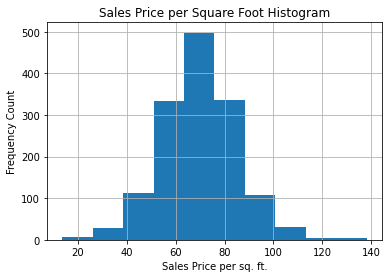

In [40]:
df_study.FE_SalePrice_Per_IndoorArea.hist()
plt.xlabel('Sales Price per sq. ft.') 
plt.ylabel('Frequency Count') 
plt.title('Sales Price per Square Foot Histogram')
plt.show()

We are able to observe a normal distribution with our new feature: total price per square feet.  Models based on a target that is normally distributed has more robust results because RMSE will not be biased by the data that are in the second half of the data. 

We want to run another correlation analysis between our new target variable - "FE_SalePrice_Per_IndoorArea" and our new variables.  We will print the top 30 results. 

In [41]:
# Show coorelation between 'Sales Price' and 'Sales Price per Sq. Ft.' with other variables
corr_table=df_study.corr()
corr_table['abs_SalePrice']=abs(corr_table['SalePrice'])
corr_table['abs_FE_SalePrice_Per_IndoorArea']=abs(corr_table['FE_SalePrice_Per_IndoorArea'])

# corr_table.to_csv('check_corr_table.csv')
corr_table.sort_values(by='abs_FE_SalePrice_Per_IndoorArea',ascending=False)[['FE_SalePrice_Per_IndoorArea','abs_FE_SalePrice_Per_IndoorArea','SalePrice','abs_SalePrice']].head(30)

,FE_SalePrice_Per_IndoorArea,abs_FE_SalePrice_Per_IndoorArea,SalePrice,abs_SalePrice
FE_SalePrice_Per_IndoorArea,1.000000,1.000000,0.640824,0.640824
SalePrice,0.640824,0.640824,1.000000,1.000000
YearBuilt,0.517898,0.517898,0.522897,0.522897
FEN_YearAfterbuilt,-0.517873,0.517873,-0.523350,0.523350
OverallQual,0.515037,0.515037,0.790982,0.790982
KitchenQual,0.502523,0.502523,0.659600,0.659600
ExterQual,0.502024,0.502024,0.682639,0.682639
FEN_YearAfterRemode,-0.488172,0.488172,-0.509079,0.509079
YearRemodAdd,0.486912,0.486912,0.507101,0.507101
GarageCars,0.442285,0.442285,0.640409,0.640409


The above table shows that the correlation between "SalePrice per sq. ft." and other variables are generally weaker than the correlation between "SalePrice" with other variables. 

The top most correlated variables are also different between the two lists.  "OverallQual", "GrLivArea", and "ExterQual" were the top 3 most corrleated variables with "SalePrice".  However, the top 3 most correlated variables with "SalePrice per sq. ft." are "YearBuilt", "OverallQual", and "KitchenQual".  These are reaonable results since newer, and higher quality houses generally are more expensive. 

Another observation that is worth pointing out is that "GrLivArea", which used to be highly correlated with "SalePrice" is not even in the top 30 most correlated variables for "SalePrice per sq. ft."  This makes sense as area shouldn't affect unit price of a house.  

Next, we will move on to build some functions to create visualizations on our variables. 

In [42]:
# create function to make plots

def categorial_feature_overview(feature,target,df, rotation=0):
    print(feature, 'has', df[feature].isnull().sum() / len(df) * 100, '% of null values')
    f,ax = plt.subplots(1, 2, figsize=(20, 6))
    ax[0].tick_params(labelrotation=rotation)
    ax[1].tick_params(labelrotation=rotation)
    sns.countplot(data=df, x=feature, ax=ax[0]);
    sns.boxplot(data=df, x=feature, y=target, ax=ax[1])
    plt.show()
    
def numerical_feature_overview(feature,target,df , rotation=0):
    print(feature, 'has', df[feature].isnull().sum() / len(df) * 100, '% of null values')
    f,ax = plt.subplots(1, 2, figsize=(20, 6))
    ax[0].tick_params(labelrotation=rotation)
    ax[1].tick_params(labelrotation=rotation)
    sns.scatterplot(data=df, x=feature, y=target, ax=ax[0]);
    sns.boxplot(data=df, x=feature, ax=ax[1])
    plt.show()
    
import plotly.graph_objects as go

def scatter_plot(feature,target,color,text,df,title,xaxis,yaxis):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df[feature], y=df[target],
        mode='markers',
        marker_color=df[color],
        text=df[text],
        marker=dict(showscale=True)
    ))
    fig.update_traces(marker_line_width=2, marker_size=10)
    fig.update_layout(title=title, xaxis_title=xaxis, yaxis_title=yaxis)
    fig.show()

### Fit a PCA model for the Area related variables

We have a total of 17 variables that are related to area. For example, "Lot Area", "MasVnrArea" and "BsmtFinSF".  Since houses with big above ground area will almost certainly have a large first floor area, we want to apply PCA to help us reduce the number of variables, yet retaining variance. 

In the next several code blocks, we will first identify all of the columns with the string "Per_IndoorArea", then we will eliminate all of the variables that are not related to area. Finally, we will run a PCA analysis and set to retain 99.9% of variance.

In [43]:
df_train_IC,col_FE_num,col_FE_cat=FeatureEngineering(df_train_IC)

In [44]:
[i for i in df_train_IC.columns if "Per_IndoorArea" in i]

['FE_SalePrice_Per_IndoorArea',
 'FEN_LotArea_Per_IndoorArea',
 'FEN_MasVnrArea_Per_IndoorArea',
 'FEN_BsmtFinSF1_Per_IndoorArea',
 'FEN_BsmtFinSF2_Per_IndoorArea',
 'FEN_BsmtUnfSF_Per_IndoorArea',
 'FEN_TotalBsmtSF_Per_IndoorArea',
 'FEN_1stFlrSF_Per_IndoorArea',
 'FEN_2ndFlrSF_Per_IndoorArea',
 'FEN_LowQualFinSF_Per_IndoorArea',
 'FEN_GrLivArea_Per_IndoorArea',
 'FEN_GarageArea_Per_IndoorArea',
 'FEN_WoodDeckSF_Per_IndoorArea',
 'FEN_OpenPorchSF_Per_IndoorArea',
 'FEN_EnclosedPorch_Per_IndoorArea',
 'FEN_3SsnPorch_Per_IndoorArea',
 'FEN_ScreenPorch_Per_IndoorArea',
 'FEN_PoolArea_Per_IndoorArea']

In [45]:
  Area_factors=['FEN_LotArea_Per_IndoorArea',
 'FEN_MasVnrArea_Per_IndoorArea',
 'FEN_BsmtFinSF1_Per_IndoorArea',
 'FEN_BsmtFinSF2_Per_IndoorArea',
 'FEN_BsmtUnfSF_Per_IndoorArea',
 'FEN_TotalBsmtSF_Per_IndoorArea',
 'FEN_1stFlrSF_Per_IndoorArea',
 'FEN_2ndFlrSF_Per_IndoorArea',
 'FEN_LowQualFinSF_Per_IndoorArea',
 'FEN_GrLivArea_Per_IndoorArea',
 'FEN_GarageArea_Per_IndoorArea',
 'FEN_WoodDeckSF_Per_IndoorArea',
 'FEN_OpenPorchSF_Per_IndoorArea',
 'FEN_EnclosedPorch_Per_IndoorArea',
 'FEN_3SsnPorch_Per_IndoorArea',
 'FEN_ScreenPorch_Per_IndoorArea',
 'FEN_PoolArea_Per_IndoorArea',]

In [46]:
pca = PCA()
df=pca.fit(df_train_IC[Area_factors])
pca.explained_variance_ratio_
print(np.cumsum(pca.explained_variance_ratio_))
print(np.cumsum(pca.explained_variance_ratio_)>0.999)

[0.98251064 0.98930887 0.9945354  0.99723126 0.9981143  0.99886643
 0.99934222 0.99964216 0.99974394 0.99983193 0.99989657 0.99995407
 0.99998278 1.         1.         1.         1.        ]
[False False False False False False  True  True  True  True  True  True
  True  True  True  True  True]


With PCA, we were able to reduce the number of area related variables from 17 to 7, which is a 60% decrease, yet retained 99.9% of the information. 

In [47]:
pca = PCA(n_components=7) # perform the PCA analysis
df=pca.fit(df_train_IC[Area_factors]) # run pca.fit

pickle.dump(pca, open("./model/pca.pkl","wb")) # save the model 

### Load the pre saved PCA model

In [48]:
pca = pickle.load(open("./model/pca.pkl",'rb'))

def pca_transform(df_input,pca_model):
  
  Area_factors=['FEN_LotArea_Per_IndoorArea',
 'FEN_MasVnrArea_Per_IndoorArea',
 'FEN_BsmtFinSF1_Per_IndoorArea',
 'FEN_BsmtFinSF2_Per_IndoorArea',
 'FEN_BsmtUnfSF_Per_IndoorArea',
 'FEN_TotalBsmtSF_Per_IndoorArea',
 'FEN_1stFlrSF_Per_IndoorArea',
 'FEN_2ndFlrSF_Per_IndoorArea',
 'FEN_LowQualFinSF_Per_IndoorArea',
 'FEN_GrLivArea_Per_IndoorArea',
 'FEN_GarageArea_Per_IndoorArea',
 'FEN_WoodDeckSF_Per_IndoorArea',
 'FEN_OpenPorchSF_Per_IndoorArea',
 'FEN_EnclosedPorch_Per_IndoorArea',
 'FEN_3SsnPorch_Per_IndoorArea',
 'FEN_ScreenPorch_Per_IndoorArea',
 'FEN_PoolArea_Per_IndoorArea',]

  df=pca_model.transform(df_input[Area_factors])
  df = pd.DataFrame(df,columns=['FEN_Area_comp0','FEN_Area_comp1','FEN_Area_comp2','FEN_Area_comp3','FEN_Area_comp4','FEN_Area_comp5','FEN_Area_comp7'],index=df_input.index)
  # display(df_original)
  return pd.concat([df_input.drop(Area_factors,axis=1) ,df],axis=1)

# pca_transform(df_study,pca)

In [49]:
df_study,col_FE_num,col_FE_cat=FeatureEngineering(df_study,pca)
df_study

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,FEC_KitchenAbvGr_dual,FEC_TotRmsAbvGrd_dual,FEC_Fireplaces_dual,FEC_GarageCars_dual,FEC_YearBuilt_dual,FEC_YearRemodAdd_dual,FEC_MoSold_dual,FEC_YrSold_dual,FEC_GarageYrBlt_dual,FEC_LotArea_dual,FEC_MasVnrArea_dual,FEC_BsmtFinSF1_dual,FEC_BsmtFinSF2_dual,FEC_BsmtUnfSF_dual,FEC_TotalBsmtSF_dual,FEC_1stFlrSF_dual,FEC_2ndFlrSF_dual,FEC_LowQualFinSF_dual,FEC_GrLivArea_dual,FEC_GarageArea_dual,FEC_WoodDeckSF_dual,FEC_OpenPorchSF_dual,FEC_EnclosedPorch_dual,FEC_3SsnPorch_dual,FEC_ScreenPorch_dual,FEC_PoolArea_dual,FEC_MiscVal_dual,FEC_LotFrontage_dual,FEN_YearAfterRemode,FEN_YearAfterbuilt,FEN_TotRmsAbvGrd_Per_GrLivArea,FEN_BsmtTotalbath,FEN_GrLivTotalbath,FEN_Area_comp0,FEN_Area_comp1,FEN_Area_comp2,FEN_Area_comp3,FEN_Area_comp4,FEN_Area_comp5,FEN_Area_comp7
0,60,RL,65.0,8450,Pave,0,1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,3,3,1,6,706,1,0,150,856,GasA,5,...,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,0,0,0,0,0,1,5,5,0.004678,1,3,-0.871755,0.100641,0.288171,-0.106300,-0.047491,0.008576,0.011476
1,20,RL,80.0,9600,Pave,0,1,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,3,3,4,5,978,1,0,284,1262,GasA,5,...,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1,31,31,0.004754,1,2,-0.357719,-0.295348,0.082468,-0.023532,-0.001949,-0.030726,-0.042403
2,60,RL,68.0,11250,Pave,0,2,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,3,3,2,6,486,1,0,434,920,GasA,5,...,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,0,0,0,0,0,1,6,7,0.003359,1,3,-0.008540,0.168035,0.156569,-0.104032,-0.054997,0.020944,0.001648
3,70,RL,60.0,9550,Pave,0,2,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,BrkTil,2,4,1,5,216,1,0,540,756,GasA,4,...,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,0,1,1,0,1,1,0,0,0,0,1,36,91,0.004077,1,1,-0.303687,0.237484,0.082421,-0.012442,-0.055000,0.036395,-0.059335
4,60,RL,84.0,14260,Pave,0,2,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,3,3,3,6,655,1,0,490,1145,GasA,5,...,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,1,8,8,0.004095,1,3,0.099926,0.149753,0.174737,-0.103836,-0.083157,0.038040,0.041444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,0,1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,3,3,1,1,0,1,0,953,953,GasA,5,...,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,1,1,0,1,0,0,0,0,0,1,7,8,0.004250,0,3,-1.122642,0.247008,-0.106856,-0.057917,-0.009146,0.006060,-0.037869
1456,20,RL,85.0,13175,Pave,0,1,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,3,3,CBlock,3,3,1,5,790,3,163,589,1542,GasA,3,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1,22,32,0.003377,1,2,-0.516358,-0.152474,0.002690,0.107071,0.069745,-0.022347,0.016709
1457,70,RL,66.0,9042,Pave,0,1,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CemntBd,None,0.0,5,4,Stone,2,4,1,6,275,1,0,877,1152,GasA,5,...,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,0,1,1,0,1,0,0,0,0

After all of our feature engineering steps above, we ended up with 148 features. 

We didnt have time to detailed study all the combinations but we found some of them interesting

### Data Visulization

#### We first visualize our variables with their original values (before recoding).

ExterQual has 0.0 % of null values


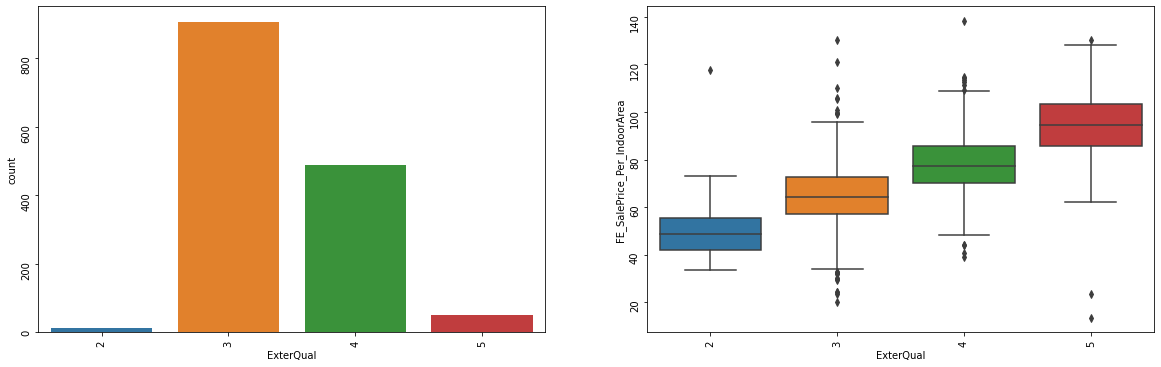

LotShape has 0.0 % of null values


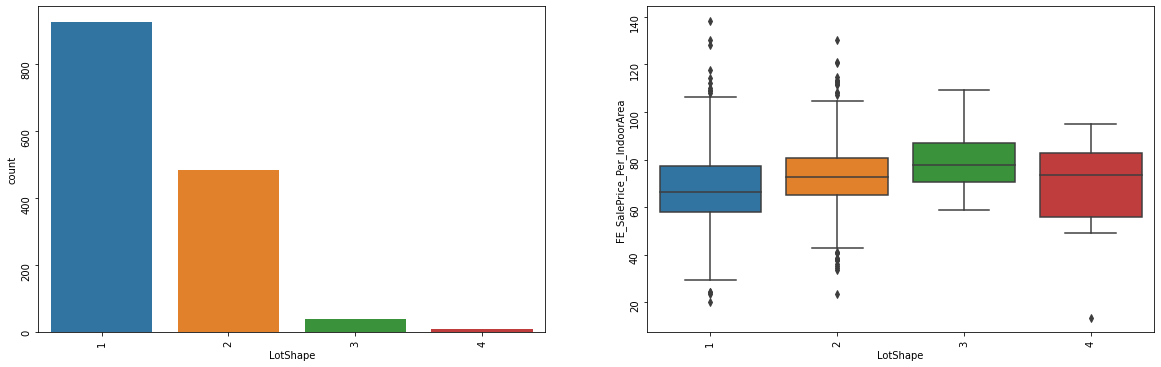

ExterCond has 0.0 % of null values


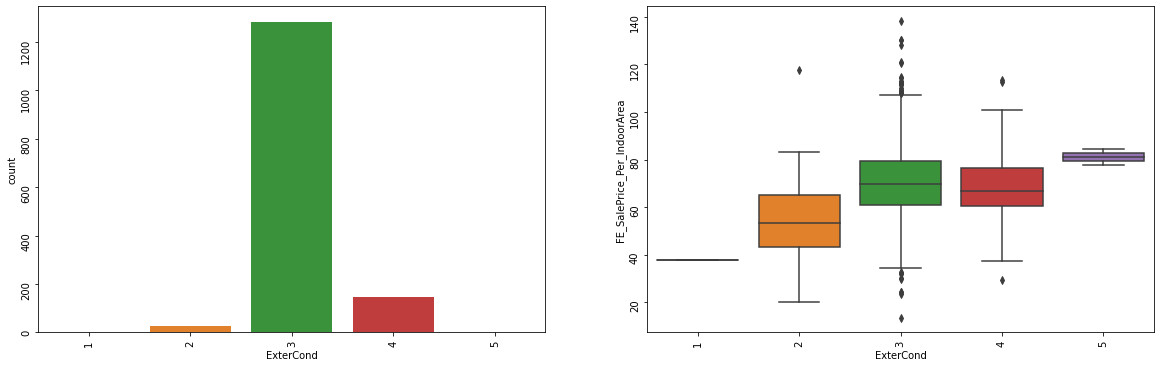

BsmtQual has 0.0 % of null values


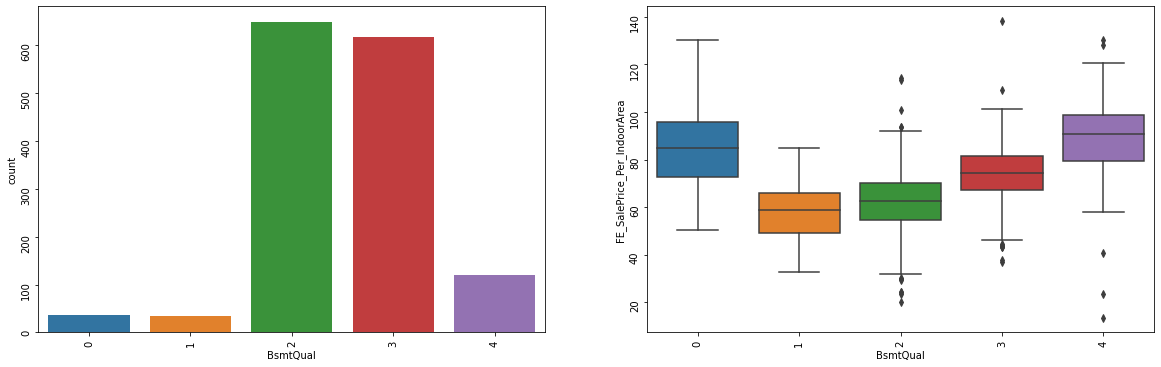

BsmtCond has 0.0 % of null values


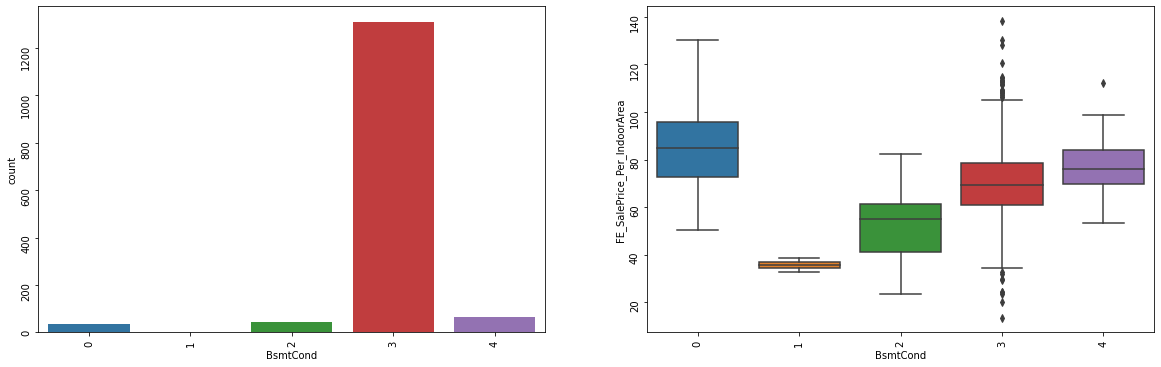

BsmtExposure has 0.0 % of null values


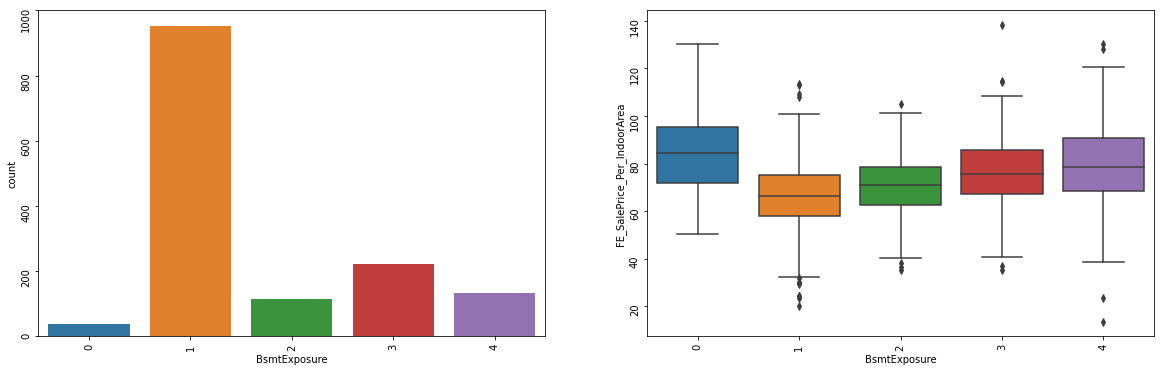

BsmtFinType1 has 0.0 % of null values


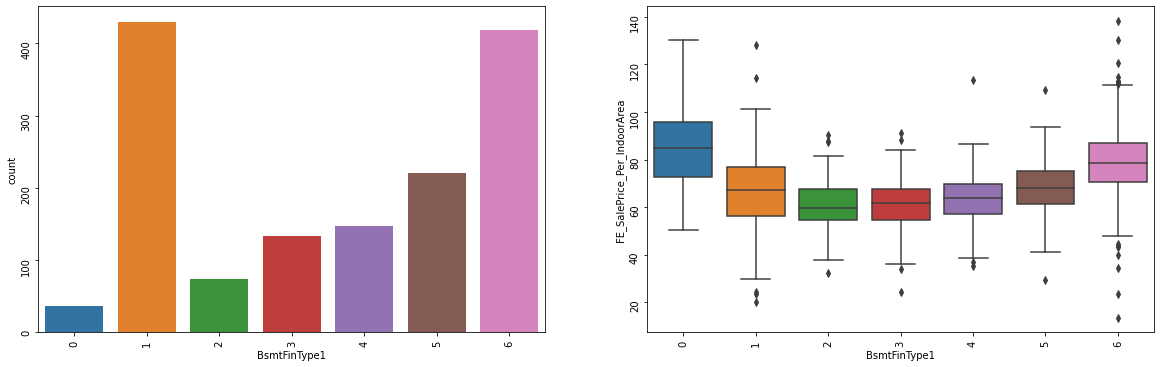

BsmtFinType2 has 0.0 % of null values


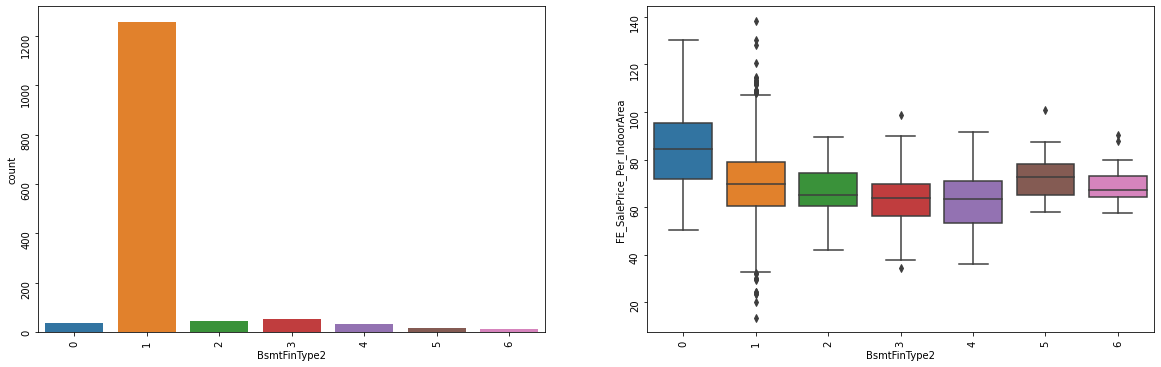

HeatingQC has 0.0 % of null values


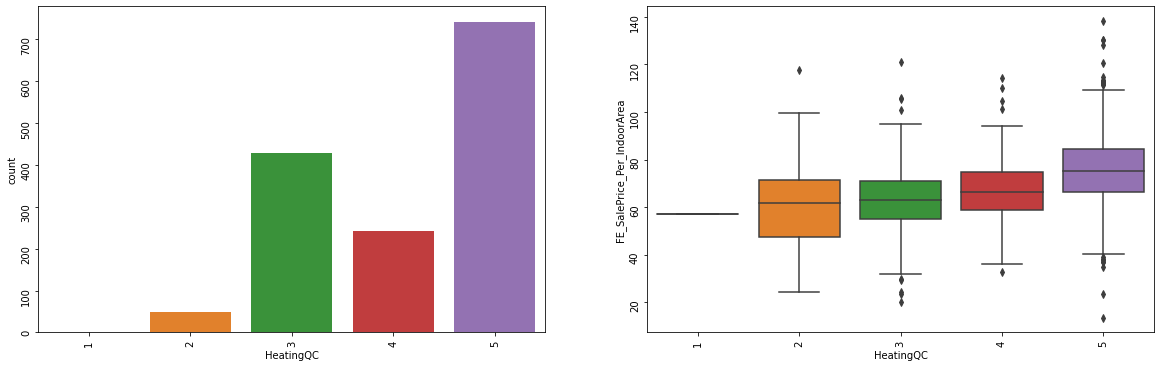

Functional has 0.0 % of null values


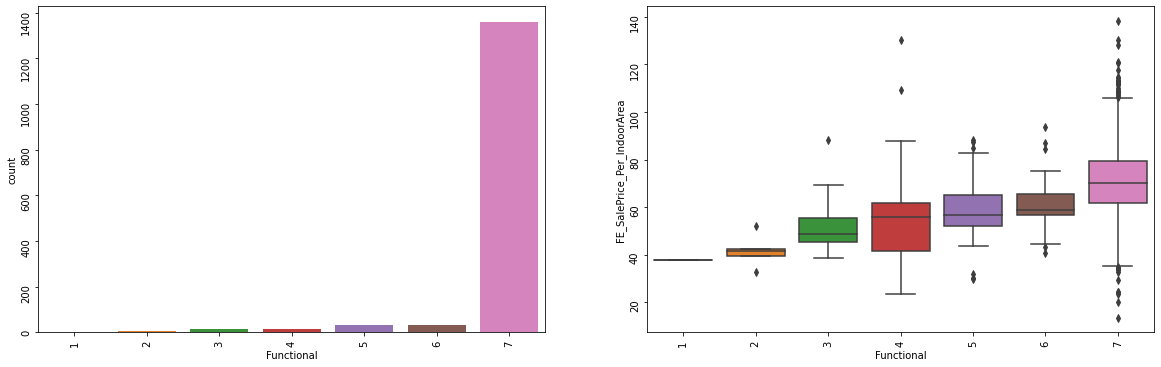

KitchenQual has 0.0 % of null values


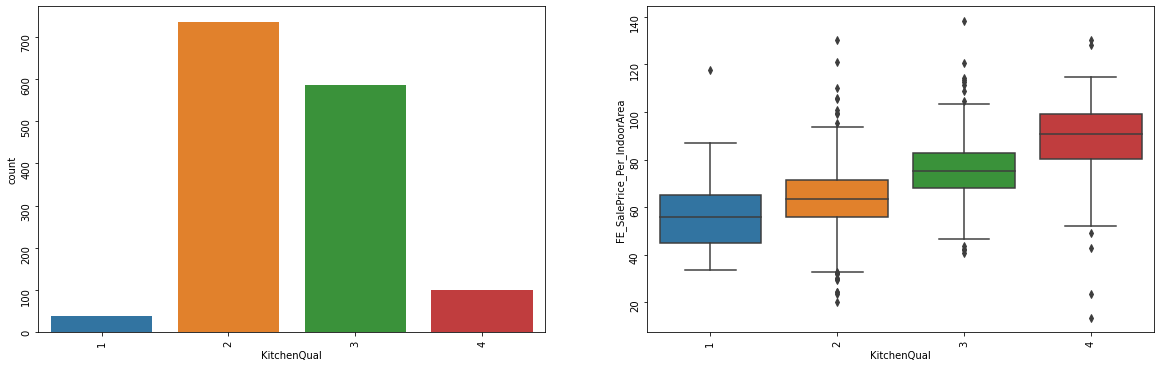

GarageQual has 0.0 % of null values


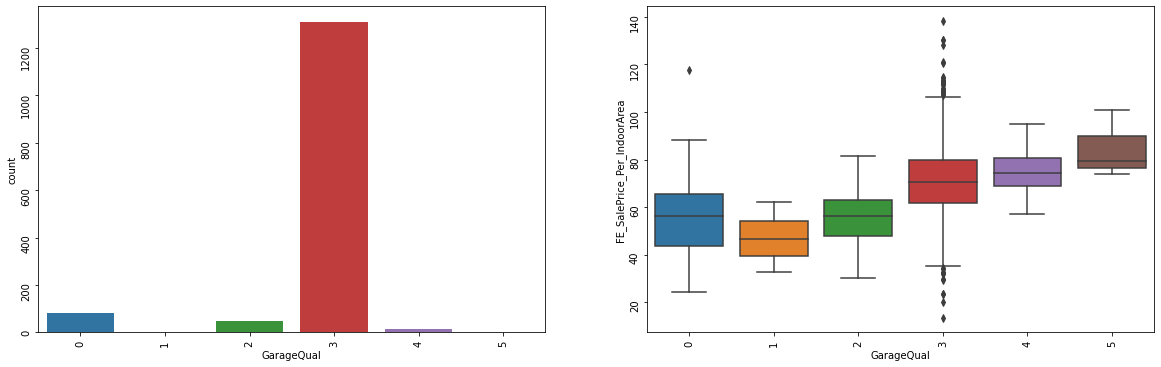

GarageFinish has 0.0 % of null values


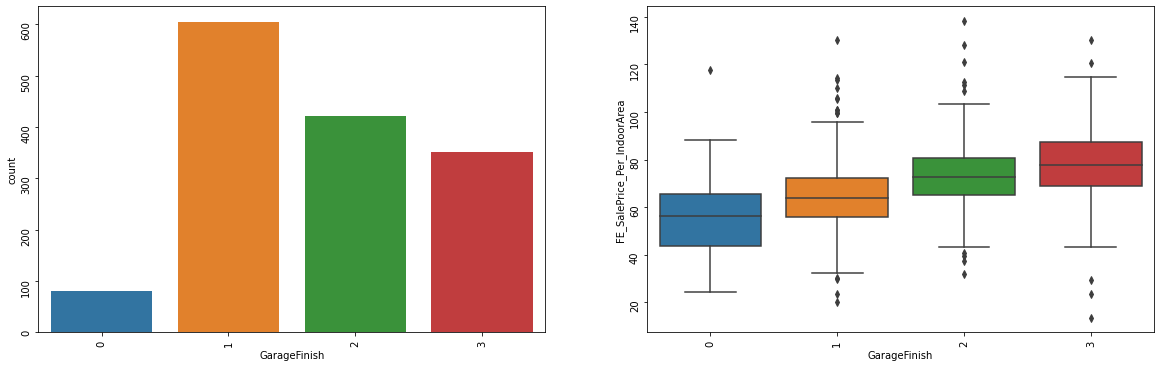

GarageCond has 0.0 % of null values


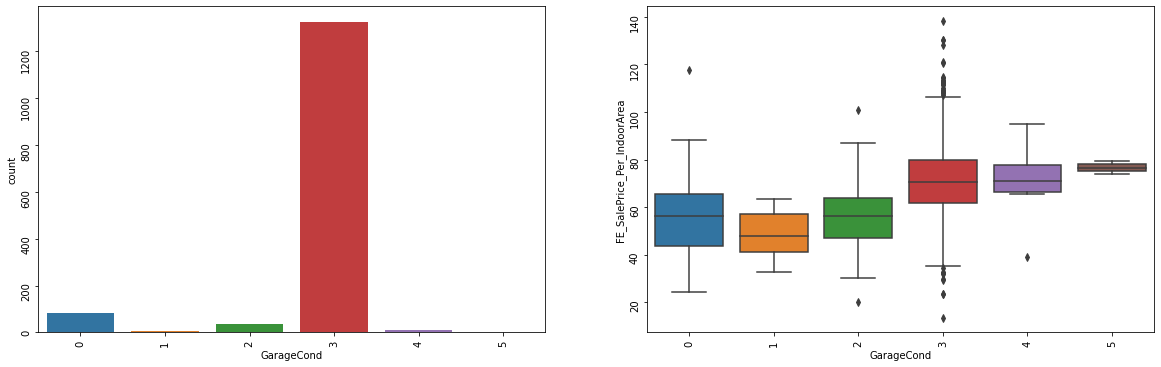

PavedDrive has 0.0 % of null values


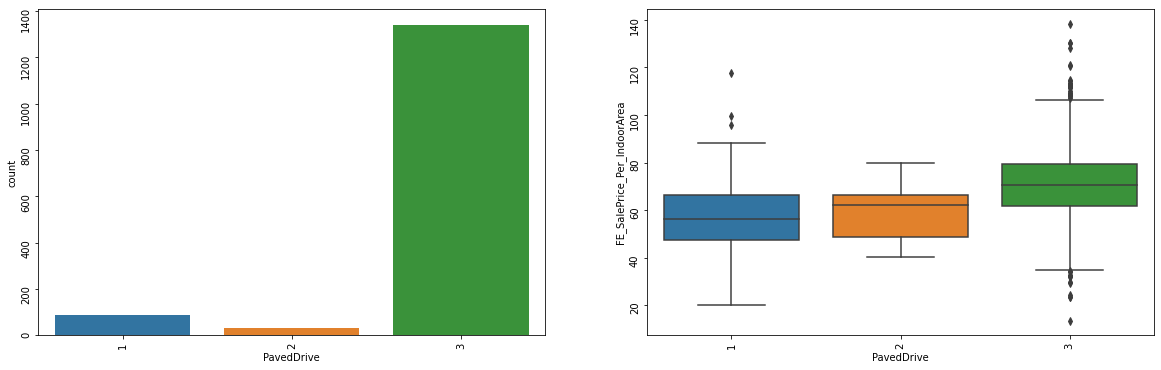

PoolQC has 0.0 % of null values


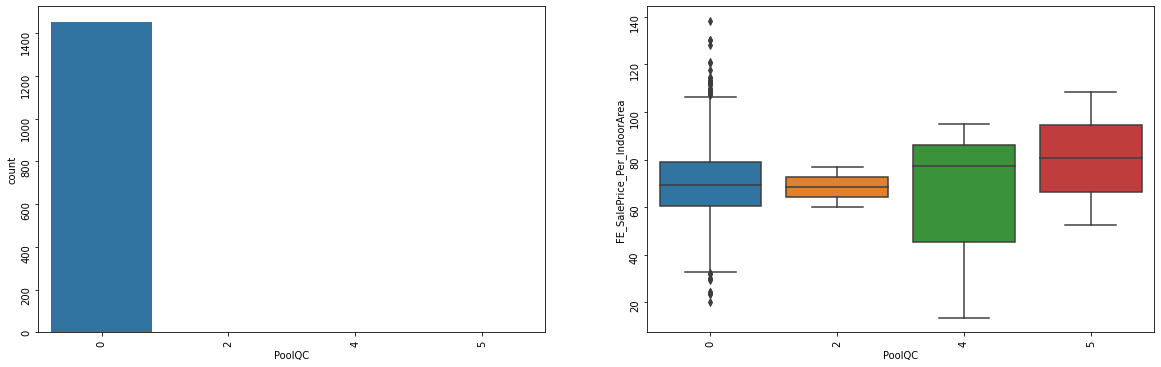

Fence has 0.0 % of null values


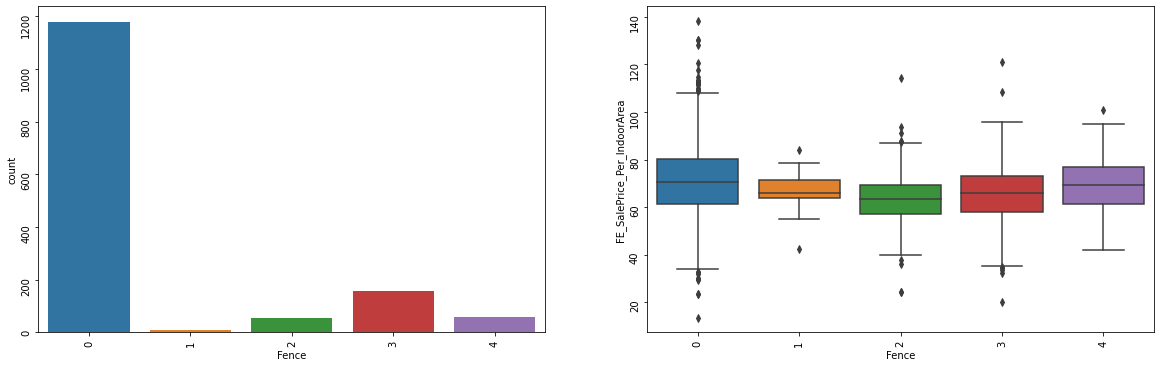

FireplaceQu has 0.0 % of null values


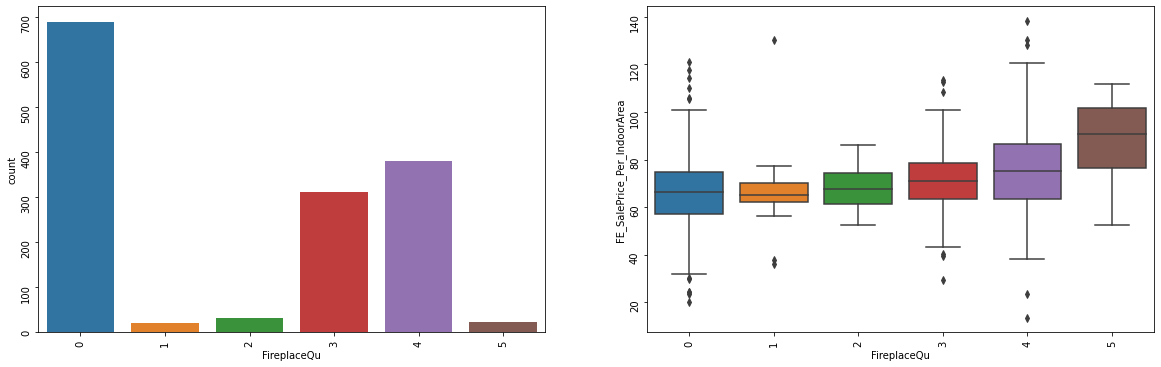

Alley has 0.0 % of null values


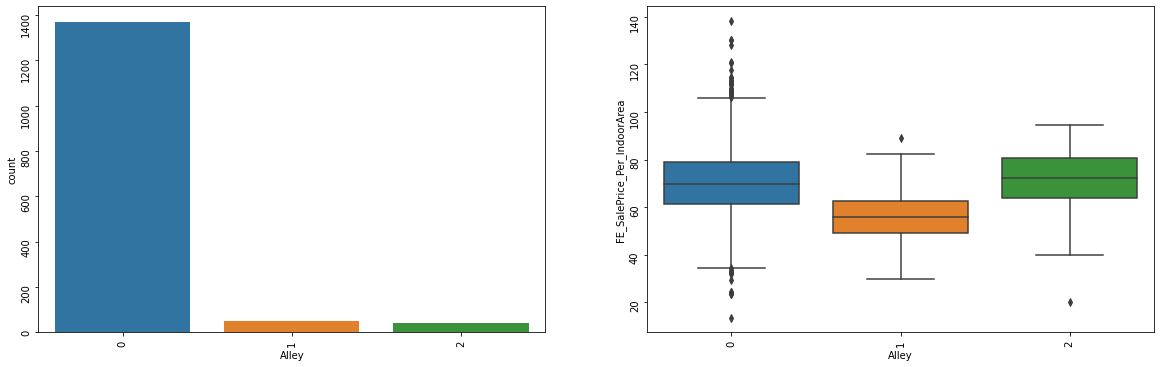

In [50]:
# # First screen with all the numerical data
# for i in col_num:
#     numerical_feature_overview(i,'FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

for i in col_order:
    categorial_feature_overview(i,'FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

# for i in col_cat:
#     categorial_feature_overview(i,'FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

TotalBsmtSF has 0.0 % of null values


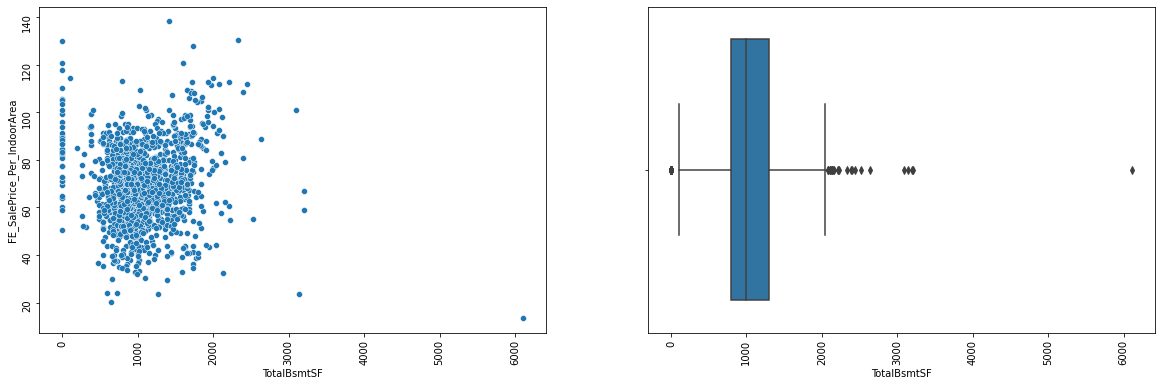

In [51]:
# Checking the relationship between Basement sq ft with Unit Price.
numerical_feature_overview("TotalBsmtSF",'FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

There is a house with an enormous basement (6,000+ sq ft). According to the box plot above, this house is considered as an outlier. However, even if we include this point in the data, there seems to be no clear correlation from the scatter plot on the left. 

BsmtFinSF1 has 0.0 % of null values


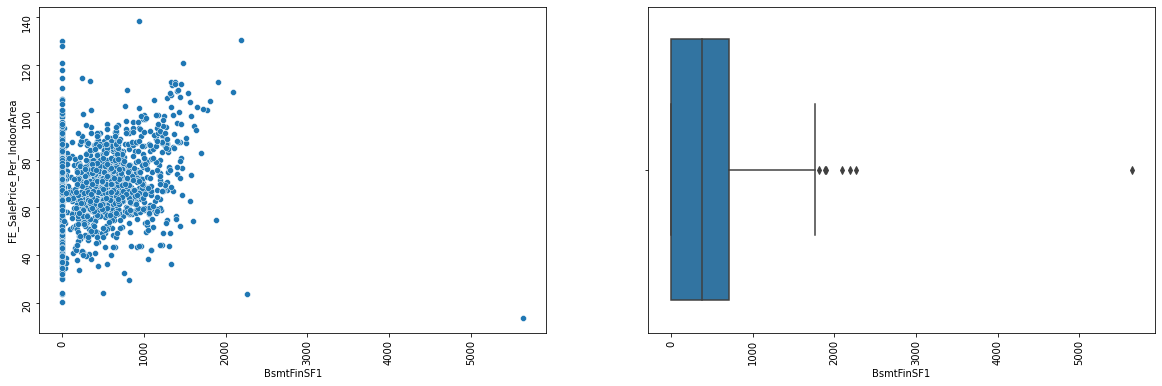

In [52]:
# Checking the relationship between Basement FIN sq ft with Unit Price.
numerical_feature_overview("BsmtFinSF1",'FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

When looking at "BsmtFinSF1", there seems to be some positive correlation between "BsmtFinSF1" with "SalePrice per sq. ft." However, it is unclear what this variable describes. 

TotalBsmtSF has 0.0 % of null values


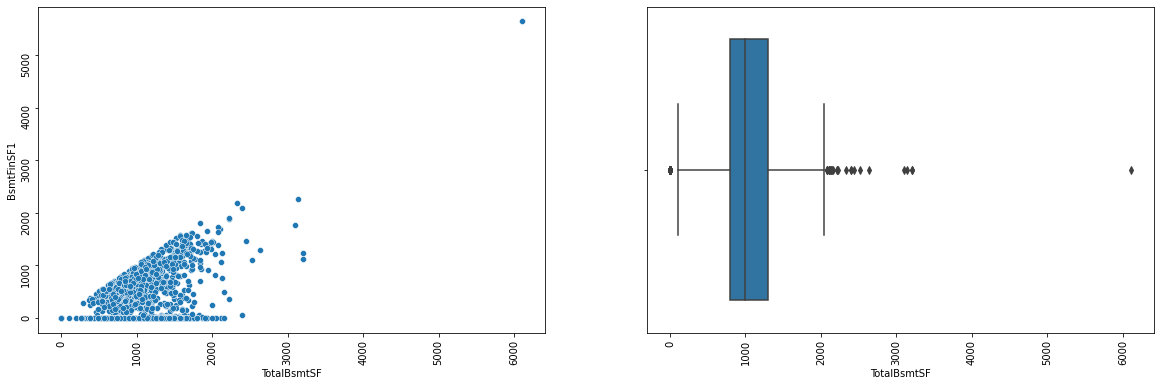

In [53]:
numerical_feature_overview("TotalBsmtSF",'BsmtFinSF1', rotation=90,df=df_study)

We want to understand the relationship between "TotalBsmtSF" and "BsmtFinSF1".  Based on the chart above, "TotalBsmtSF" is bounded by "BsmtFinSF1" and they are correlated.

1stFlrSF has 0.0 % of null values


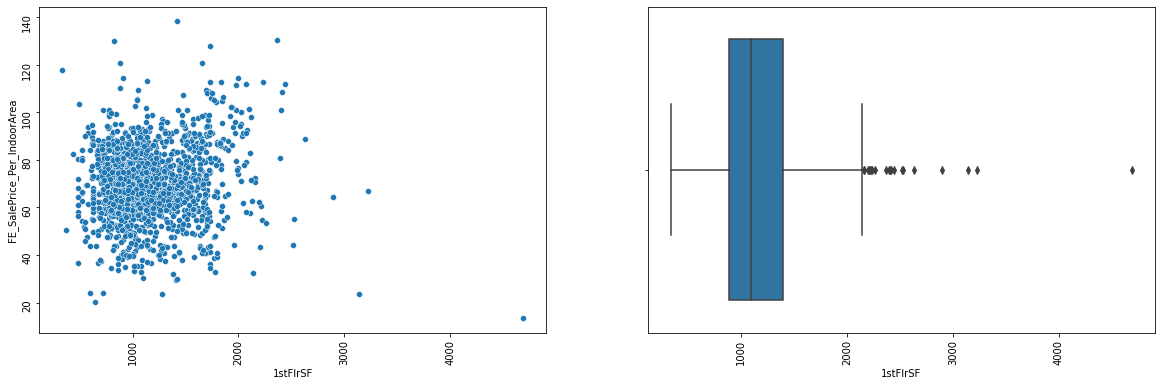

In [54]:
numerical_feature_overview("1stFlrSF",'FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

Based on the chart above, we can conclude that "1stFlrSF" is not corrleated with "SalePrice per sq. ft."  This make sense as the size of the house shouldn't affect the unit price of the house on a per square foot basis. 

GarageQual has 0.0 % of null values


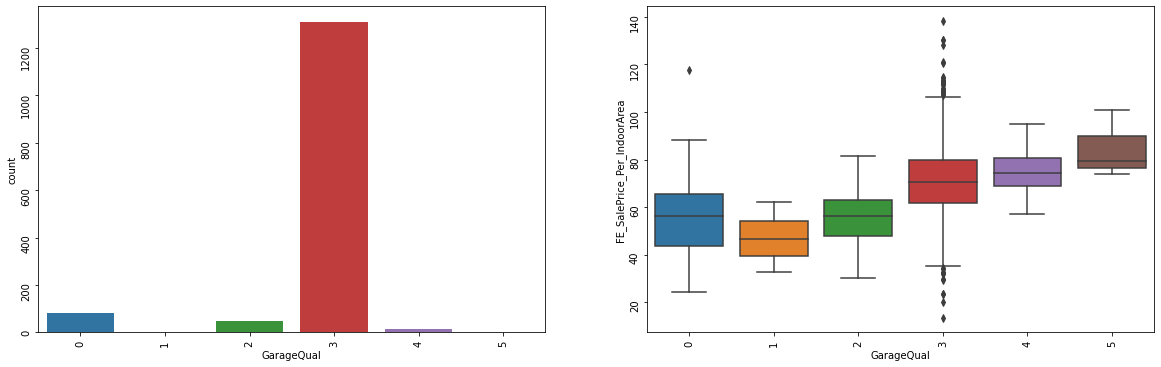

In [55]:
categorial_feature_overview('GarageQual','FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

It seems that the 0s we used to replace the Nulls did not help the model to improve its accuracy as the unit price is not Monotonic along with the order.
We could consider to add one more column to record if there is Null in the column or not just to seperate the data for easy pattern extraction

OverallQual has 0.0 % of null values


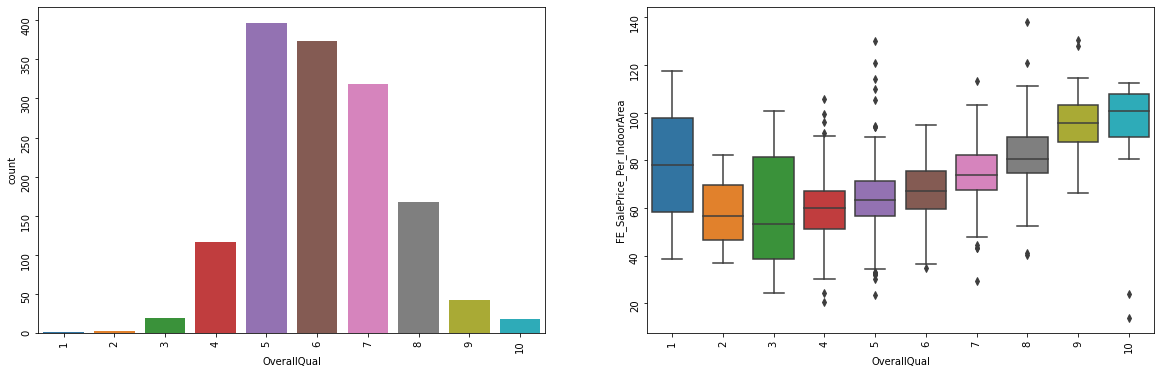

In [56]:
categorial_feature_overview('OverallQual','FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

There are only several houses with an "OverallQual" of 1 and 2.  Their relationship with "SalePrice per sq. ft." may not be reliable due to limited records. Looking at the chart on the right, if we disregard "OverallQual" of 1 and 2 because of their limited records, then as "OverallQual" increases, the "SalePrice per sq. ft." also increases.  This makes sense.  If the house has a better overall quality, it should be able to sell at a higher price. 

OverallCond has 0.0 % of null values


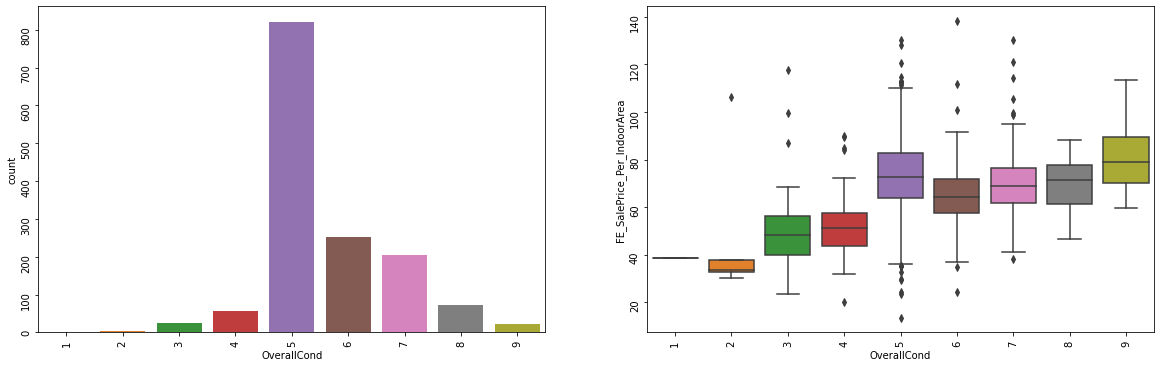

In [57]:
categorial_feature_overview('OverallCond','FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

It is suprising that houses with better overall condition do not necessarily have higher unit price.
We may want to dig into it more to understand why that is the case.
One explanation is that the house may be in an excellent condition, but it lacks other amenities or is located in a less ideal location. 

BedroomAbvGr has 0.0 % of null values


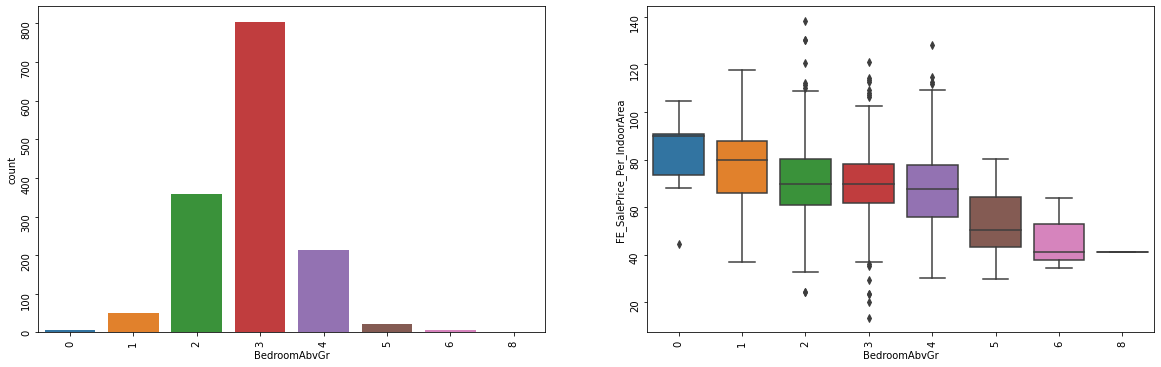

In [58]:
categorial_feature_overview('BedroomAbvGr','FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

Based on the charts above, it appears that number of bedroom above ground is negatively correlated with "SalePrice per sq. ft.". That is, the more bedrooms a house has, the lower its "SalePrice per sq. st."   Additionally, most houses have 2-4 bedrooms. 

Neighborhood has 0.0 % of null values


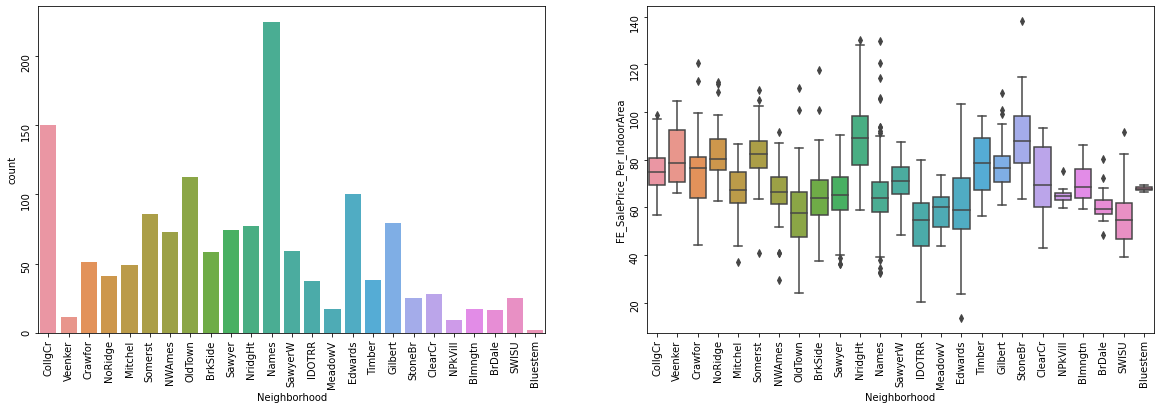

In [59]:
categorial_feature_overview('Neighborhood','FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

Neighborhood seems to be one of the reasons to affect the "SalePrice per sq. ft."
But still, there are huge variations within a single neighborhood.
Understanding more about the neighborhoods should help us understand its impact on "SalePrice per sq. ft." For example, do neighborhoods that are closer in promixity tend to have similar "SalePrice per sq. ft.?  This is something that our current dataset cannot answer.  We will note that as a next step we can pick up again in future studies. 

SaleCondition has 0.0 % of null values


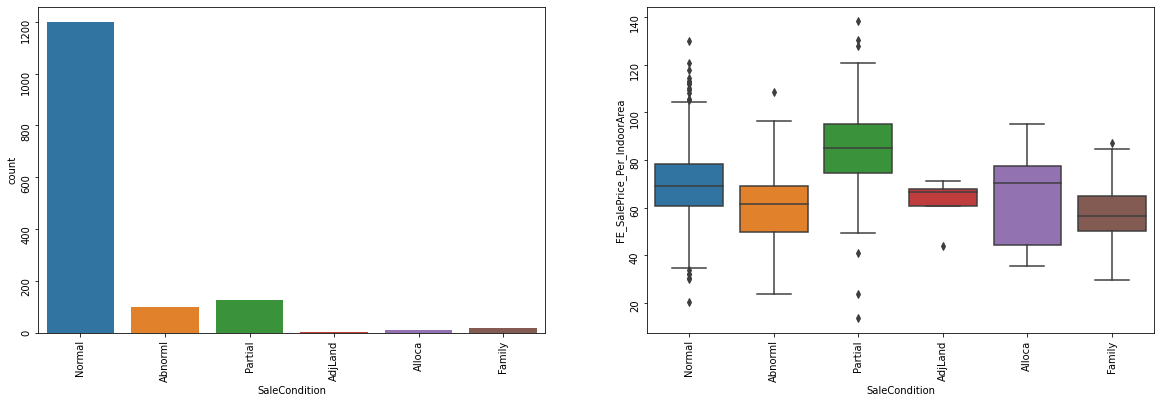

In [60]:
categorial_feature_overview('SaleCondition','FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

We have previously thought that "SalePrice per sq. ft." should be relatively similar across different "SaleConition". 
However, as we read more into the chart on the right, we realized our intuition was wrong. Sale condiiton of "Partial" means the house is brand new, while sale condition of "Abnormal" means the house was foreclosed.  It makes sense that a forecloased house would sell at a lower unit price because the financial institution would rather get the cash quicker than waiting for the highest bidder. 

SaleType has 0.0 % of null values


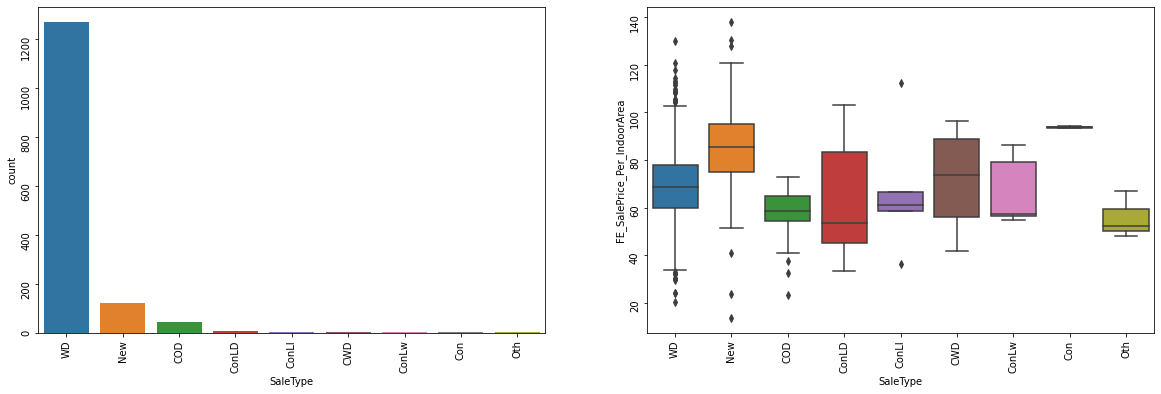

In [61]:
categorial_feature_overview('SaleType','FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

"SaleType" has a very similar hisogram distribution with "SaleCondition".  

Next, we will look at several scatter plots to hopefully help us understand our variables more.

In [62]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [63]:
configure_plotly_browser_state()

scatter_plot(
    feature='YearBuilt',
    target='FE_SalePrice_Per_IndoorArea',
    color='OverallQual',
    text='BsmtQual',
    df=df_study,
    title="Yearbuilt vs SalePrice per sq. ft. with OverallQual",
    xaxis="year built",
    yaxis="SalePrice Per GrLivArea")


it is clearly that the new houses have higher unitprice, with the same year built the better quality the higher unit price will be.
two outliners in the right bottom are worth to be checked.

In [64]:
configure_plotly_browser_state()

scatter_plot(
    feature='BsmtFinSF1',
    target='FE_SalePrice_Per_IndoorArea',
    color='BsmtQual',
    text='BsmtFinType1',
    df=df_study,
    title="BaseFinSF1 vs SalePrice per sq. ft. with Basement Quality",
    xaxis="basement area",
    yaxis="unit price"
)

As we checked before, it seems that the bigger the basement is the higher and the higher quality of the basement the higher the price will be.
But still when the basement area is larger than 2000 square feet, it doesnt seems to follow the rule.

In [65]:
configure_plotly_browser_state()

scatter_plot(
    feature='BsmtQual',
    target='FE_SalePrice_Per_IndoorArea',
    color='BsmtQual',
    text='BsmtFinType1',
    df=df_study,
    title="Basement Quality vs SalePrice per sq. ft. with Basement Quality",
    xaxis="basement quality",
    yaxis="unit price"
)

### Viewing our new variables from feature engineering below

In [66]:
configure_plotly_browser_state()
scatter_plot(
    feature='BsmtQual',
    target='FE_SalePrice_Per_IndoorArea',
    color='FEN_Area_comp2',
    text='BsmtQual',
    df=df_study,
    title="Basement Quality vs SalePrice per sq. ft. with Area PCA n=2",
    xaxis="Basement Quality",
    yaxis="SalePrice per sf")


YrSold has 0.0 % of null values


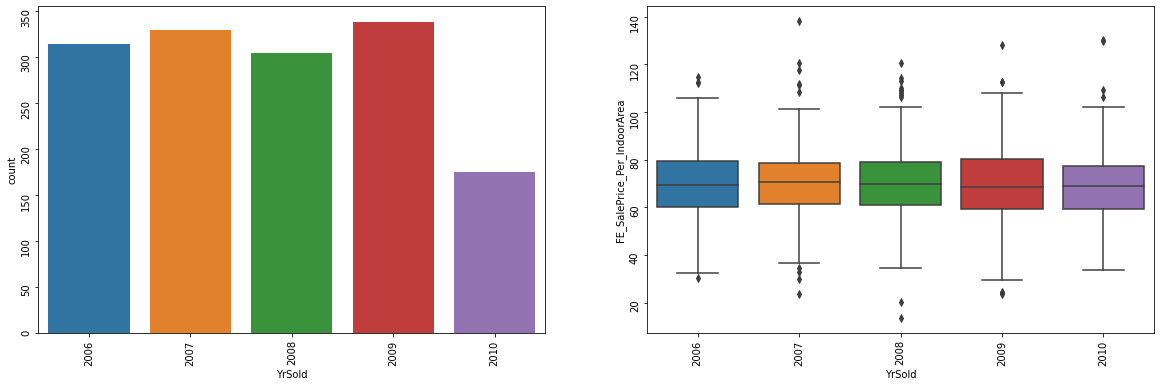

FEN_YearAfterRemode has 0.0 % of null values


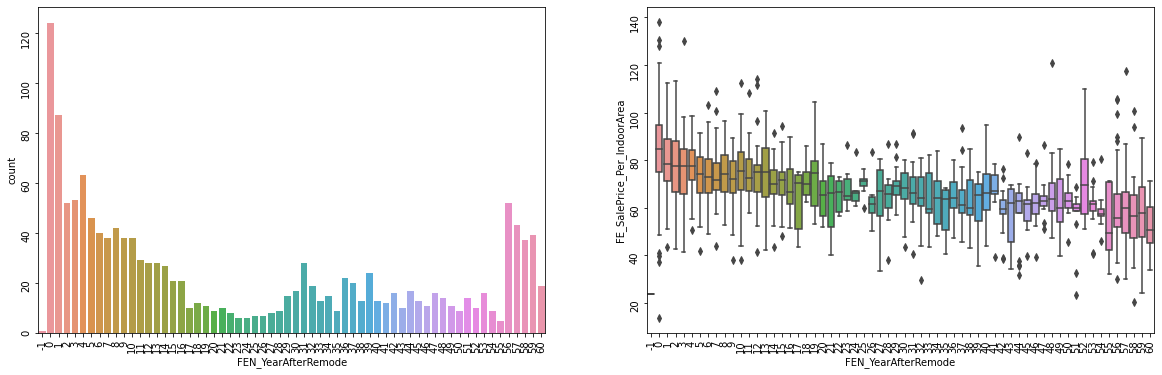

In [67]:
categorial_feature_overview("YrSold",'FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)
categorial_feature_overview("FEN_YearAfterRemode",'FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

Looking at "YearSold" vs "SalePrice per sq. ft", the trend is quite stable from 2006 to 2010.  The mean "SalePrice per sq. ft." across years are consistent. 

When moving to "Year after remodel", we see that there are some values where this field is -1.  We believe this means there were house sold before they could finish remodeling.  However, the generally is decreasing - as "Year after remodel" gets larger, "SalePrice per sq. ft." tend to drop. 

BsmtCond has 0.0 % of null values


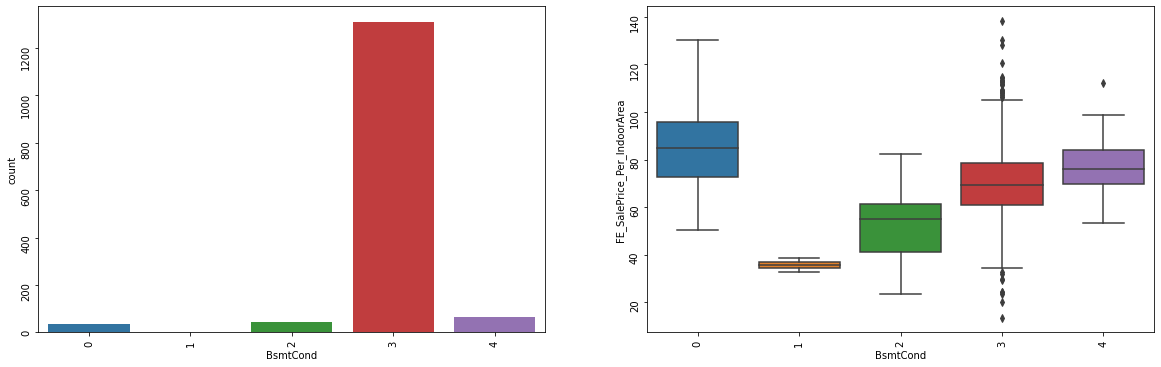

FEC_BsmtCond_dual has 0.0 % of null values


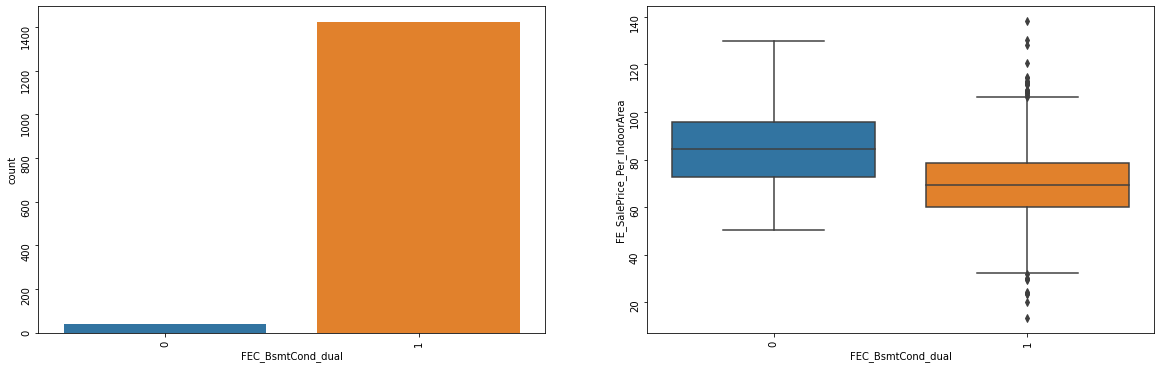

In [68]:
categorial_feature_overview("BsmtCond",'FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)
categorial_feature_overview("FEC_BsmtCond_dual",'FE_SalePrice_Per_IndoorArea', rotation=90,df=df_study)

In our feature engineering step above, we first recoded the values of categorial and ordinal variables to 0 when they are None or Nulls.   Then we recoded them further into binary - if the values don't equal 0, then 1, otherwise 0.  

From what we can see below, the 0s behave very differently from the non-0s values 

We wouldn't have been able to view this information if we hadn't recoded the values. 


## Pipe line

Apply OneHotEncoder

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. It will split the categorical variables into different binary columns, representing the unique values from those variables.

https://www.kaggle.com/alexandrasciocchetti/housing-prediction-w-pipeline-ensemble-methods

In [69]:
# numerical_cols=col_num_continuous+col_num_int+col_FE+col_norm
# categorical_cols=col_cat+col_order

numerical_cols=col_num_continuous+col_FE_num+col_norm
categorical_cols=col_cat+col_order+col_num_int+col_FE_cat
# col_nonimp=["OpenPorchSF","YrSold","Electrical","BsmtHalfBath","FE_ScreenPorch_Per_GrLivArea","MoSold","HalfBath","GarageCond","FE_1stFlrSF_Per_GrLivArea","MiscVal","Street","FE_BsmtUnfSF_Per_GrLivArea","Exterior1st","RoofStyle","FE_1stFlrSF_Plus_2ndFlrSF_Plus_per_GrLivArea","YearRemodAdd","GarageYrBlt","LowQualFinSF","Heating","LandSlope","PoolArea","LotConfig","FE_MasVnrArea_Per_GrLivArea","2ndFlrSF","3SsnPorch","BsmtFinSF2","FE_PoolArea_Per_GrLivArea","WoodDeckSF","FE_BsmtFinSF2_Per_GrLivArea","FE_MiscVal_Per_GrLivArea","FE_LowQualFinSF_Per_GrLivArea","FE_3SsnPorch_Per_GrLivArea","FE_Totalbath","FE_BsmtUnfSF_Per_2ndFlrSF","Utilities",]
col_nonimp=[i for i in col_num_continuous if i not in ["LotFrontage","MiscVal"] ]

col_cat_final=[i for i in col_cat+col_order+col_num_int if i not in col_nonimp]

# numerical_cols= [i for i in df_train_IC.columns if i not in col_cat_final]


In [70]:
#define transform strategy Normalizer
numerical_transformer =  SimpleImputer(missing_values =np.nan,strategy='mean')


#categorical columns are encoded during this step
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [71]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

def process_and_fit(model, train, target):
    pipeline = Pipeline(steps=[('preprocess', preprocess),
                   ('scale', StandardScaler(with_mean=False)),
                   ('model', model)])
    pipeline.fit(train, target)
    return pipeline

def rmse(validation, target):
    return np.sqrt(mean_squared_error(validation, target))


def mape(validation, target):
    return np.sqrt(mean_absolute_percentage_error(validation, target))

## Generate Train and Dev data

In [72]:
col_target='FE_SalePrice_Per_IndoorArea'

df_original_IC=ImputerConverter(df_original,col_num_continuous+col_num_int,col_order,col_cat,orders_encoding_result)
df_train_IC=ImputerConverter(df_train,col_num_continuous+col_num_int,col_order,col_cat,orders_encoding_result)
df_dev_IC=ImputerConverter(df_dev,col_num_continuous+col_num_int,col_order,col_cat,orders_encoding_result)       

df_train_IC,col_FE_num,col_FE_cat=FeatureEngineering(df_train_IC,pca)
df_dev_IC,col_FE_num,col_FE_cat=FeatureEngineering(df_dev_IC,pca)

In [73]:
X_train=df_train_IC[numerical_cols+categorical_cols]
y_train=df_train_IC[col_target].to_numpy().ravel()



X_valid=df_dev_IC[numerical_cols+categorical_cols]
y_valid=df_dev_IC[col_target].to_numpy().ravel()

## Base Models of Random Forest, KNN, XG Boosting

We experimented with several models - Random Forest, KNN and XGB boosting.

**Random Forest** is a combination of decision tress that canbe modeled for prediction and bahavior analysis. It contains many decision trees representing a distinct instance of the classification of data input into the model. It can handle large datasets thanks to its capability to work with many variables. 

**KNN** is a non-parametric machine learning algorithm that can be used for classification and regression. It uses "feature similiarity" to predict the values of any new data points. This means the new point is assigned a value based on how closely it resembles the points int he training set. 

eXtreme Gradient Boosting (XGB) uses the gradient boosting decision tree algorithm. Boosting is an ensemble technique where new models are sequentially added to correct errors made by existing models until no further improvements can be made. It dominates structured or tabulat datasets on classification and regression predictive modeling problems. 

We are using these models because Random Forest and KNN are models we learned from class and XGB was recommended by instructors.  

In [74]:
#Random Forest 
randomForest = RandomForestRegressor(n_estimators=1000, random_state=42)
KNN=KNeighborsRegressor(n_neighbors=3)
XGB_model = XGBRegressor(n_estimators=1000,random_seed=42, learning_rate=0.05,tree_method='gpu_hist', objective='reg:squarederror')

rfPipeline = process_and_fit(randomForest, X_train, y_train)
rfTrain = rfPipeline.predict(X_train)*X_train['FEN_IndoorArea']
rfPred = rfPipeline.predict(X_valid)*X_valid['FEN_IndoorArea']

knnPipeline = process_and_fit(KNN, X_train, y_train)
knnTrain = knnPipeline.predict(X_train)*X_train['FEN_IndoorArea']
knnPred = knnPipeline.predict(X_valid)*X_valid['FEN_IndoorArea']

xgbPipeline = process_and_fit(XGB_model, X_train, y_train)
xgbTrain = xgbPipeline.predict(X_train)*X_train['FEN_IndoorArea']
xgbPred = xgbPipeline.predict(X_valid)*X_valid['FEN_IndoorArea']


models = [
          'Random Forest',
          'KNN',
          'XGBoost'
# #           , 'Gradient Boosting', 'Cat Boost', 'XGBoost', 'Lasso Regression', 'Light GBM'
         ]
models_val = {
    'Random Forest': rfPred,
              'KNN':knnPred,
              'XGBoost':xgbPred
#                , gbPred, cbPred, lassoPred, gbmPred
          }

models_train = {
    'Random Forest': rfTrain,
              'KNN':knnTrain,
              'XGBoost':xgbTrain
#                , gbPred, cbPred, lassoPred, gbmPred
          }

result={}
for m in models:
    score ={'Train': rmse(df_train_IC['SalePrice'], models_train[m]),
            'Val': rmse(df_dev_IC['SalePrice'], models_val[m])}
    result[m]=score

result

{'KNN': {'Train': 31393.47671008481, 'Val': 32175.767111299265},
 'Random Forest': {'Train': 14336.33449387324, 'Val': 24520.219295722047},
 'XGBoost': {'Train': 6565.340704466781, 'Val': 21362.773508505594}}

## Base Model Catboost

#### Data set definition

In [75]:
col_cat_final=[i for i in col_cat+col_order+col_num_int if i not in col_nonimp]

# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=col_cat_final)
test_pool = Pool(X_valid, 
                 y_valid,
                 cat_features=col_cat_final)

In [76]:
# specify the training parameters 
model = CatBoostRegressor(iterations=1000, 
                          random_seed=42,
                          learning_rate=0.01, 
                          loss_function='RMSE',verbose=False
                          , task_type='GPU')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
preds = model.predict(train_pool)*X_train['FEN_IndoorArea']
print('train rmse: ',rmse(df_train_IC['SalePrice'], preds))

preds = model.predict(test_pool)*X_valid['FEN_IndoorArea']
print('val rmse: ',rmse(df_dev_IC['SalePrice'], preds))
# print(preds)

train rmse:  26675.339257582767
val rmse:  23456.77378026224


In [77]:
# pd.DataFrame({'feature_importance': model.get_feature_importance(train_pool), 
#               'feature_names': X_valid.columns}).sort_values(by=['feature_importance'], 
#                                                            ascending=False).iloc[:30,]

## Optuna for parameter tunning

Build the data pool after triming not important columns

In [78]:
# initialize Pool
train_pool = Pool(X_train.drop(col_nonimp,axis=1), 
                  y_train, 
                  cat_features=col_cat_final)
test_pool = Pool(X_valid.drop(col_nonimp,axis=1), 
                 y_valid,
                 cat_features=col_cat_final)

### Define the object function

In [79]:


def objective(trial):
    params = {
        # 'iterations':trial.suggest_int('iterations', 10000, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 0, 12),
        'loss_function':'RMSE',
        'task_type':'GPU',
        'random_seed':4,
        'logging_level':'Silent'
    }

    model = CatBoostRegressor(**params,)
    model.fit(train_pool, verbose=0,eval_set=test_pool,early_stopping_rounds=50)
    preds = model.predict(test_pool)*X_valid['FEN_IndoorArea']

    return rmse(df_dev_IC['SalePrice'], preds)

    # option we could use, need to change loss function into MAPE through
    # , mape(df_dev_IC['SalePrice'], preds)
    # rmse(np.log(df_dev_IC['SalePrice']), np.log(preds))
    # 



### Define the study

In [80]:
study_name = 'example-study-103'  # Unique identifier of the study.
storage_file_name= 'sqlite:///study_record.db'
# sampler = optuna.samplers.NSGAIISampler()
study = optuna.create_study(directions=["minimize"
                                        # ,"minimize"
                                        ],
  study_name=study_name, storage='sqlite:///study_record.db',load_if_exists=True)

[I 2021-12-05 09:08:06,815] Using an existing study with name 'example-study-103' instead of creating a new one.


### Conduct the study

In [81]:
# sampler = TPESampler(seed=123)
study.optimize(objective, 
              #  timeout =11.5*60*60,
              n_trials=1
               )

[I 2021-12-05 09:08:10,986] Trial 310 finished with value: 21689.57623447983 and parameters: {'learning_rate': 0.5180208794323087, 'depth': 6, 'l2_leaf_reg': 5.579609911053298, 'boosting_type': 'Plain', 'max_ctr_complexity': 2}. Best is trial 176 with value: 19901.915161143737.


## Finalize the model

In [82]:
param=study.best_trial.params

param.update({'loss_function':'RMSE',
        'task_type':'GPU',
        'random_seed':4,
        'logging_level':'Silent'})

param

{'boosting_type': 'Plain',
 'depth': 5,
 'l2_leaf_reg': 5.464804976966055,
 'learning_rate': 0.08943915485210002,
 'logging_level': 'Silent',
 'loss_function': 'RMSE',
 'max_ctr_complexity': 6,
 'random_seed': 4,
 'task_type': 'GPU'}

In [83]:
scores = cv(pool=train_pool,
   params=param,
   plot="False",
   early_stopping_rounds=50,
   )

scores.sort_values(['test-RMSE-mean'],ascending=True).head(30)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
584,584,8.563257,0.549742,3.455923,0.164493
573,573,8.563539,0.549784,3.490996,0.186155
580,580,8.563703,0.549560,3.468407,0.173715
582,582,8.563853,0.549081,3.461734,0.169187
585,585,8.564216,0.549130,3.453626,0.165202
581,581,8.564248,0.548839,3.464853,0.170375
566,566,8.564316,0.548710,3.514703,0.204268
565,565,8.564624,0.548519,3.516938,0.206423
586,586,8.564774,0.548775,3.452800,0.165480
583,583,8.564867,0.547995,3.458355,0.165212


In [84]:
model = CatBoostRegressor(**param)
model.fit(train_pool, verbose=0, eval_set=test_pool,early_stopping_rounds=50)


### Evaluate the final model

In [85]:
preds = model.predict(train_pool)*X_train['FEN_IndoorArea']
rmse(df_train_IC['SalePrice'], preds)

17000.21240854083

In [86]:
preds = model.predict(test_pool)*X_valid['FEN_IndoorArea']
rmse(df_dev_IC['SalePrice'], preds)

19901.915161143737

 Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Kaggle metric)

In [87]:
preds = model.predict(test_pool)*X_valid['FEN_IndoorArea']
rmse(np.log(df_dev_IC['SalePrice']), np.log(preds))

0.10776608841291475

### Get feature importance

In [88]:
feature_importance=pd.DataFrame({'feature_importance': model.get_feature_importance(train_pool), 
              'feature_names': X_valid.drop(col_nonimp,axis=1).columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

feature_importance.to_csv('Feature_importance.csv',index=False)
feature_importance.iloc[:30,]

,feature_importance,feature_names
2,9.775128,FEN_IndoorArea
3,8.006888,FEN_YearAfterRemode
10,7.865194,FEN_Area_comp2
43,6.149208,BsmtQual
22,5.523920,Neighborhood
59,5.084397,OverallQual
8,4.702522,FEN_Area_comp0
12,4.449777,FEN_Area_comp4
50,4.053901,KitchenQual
4,3.993363,FEN_YearAfterbuilt


### Save Model

In [89]:
# pickle.dump(model, open("./model/model.pkl","wb"))

## Model Explaination

Explain by SHAP

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Catboost%20tutorial.html

In [90]:
model = pickle.load(open("./model/model.pkl",'rb'))

In [91]:
import shap

In [92]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid.drop(col_nonimp,axis=1))

In [93]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_valid.drop(col_nonimp,axis=1))

Output hidden; open in https://colab.research.google.com to view.

In [94]:
# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_valid.drop(col_nonimp,axis=1).iloc[0,:])

## Prediction on Test data will be conducted by seperate notebook.

# Summary of model accuracy

| SN | Type | Model | Feature | Num Feature | RMSE | Metric Kaggle |
| --- | --- | --- | --- | --- | --- | --- |
|0| Base line Model | Random Forest | Original - Featur with most value missing  |73| 29,433 ||
|1| Comparing Model | KNN | Original + Feature Engineering |129| 32,175 ||
|2| Comparing Model | Random Forest | Original + Feature Engineering |129| 24,520 ||
|3| Comparing Model | XGBoost+ Tunning | Original + Feature Engineering |129| 21,362 |
|4| Final Model | CatBoost+Optuna Tunning | Original + Feature Engineering  |129| 19,901 |1.01(dev)/1.29(kaggle) |

